XGBoost Regression - 'real-world' example: Californian Housing Dataset

https://scikit-learn.org/stable/datasets/real_world.html#california-housing-dataset

In [ ]:
!pip install pyGPGO

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 5.1 MB/s 
     |████████████████████████████████| 872 kB 40.4 MB/s 
  Created wheel for pyGPGO: filename=pyGPGO-0.5.1-py3-none-any.whl size=19879 sha256=c812f5830032bfc9a2bf654ef8d54ecfc17340c9024d67736dd9e9bdd4e46059
  Stored in directory: /root/.cache/pip/wheels/c8/5d/0b/2160114e2f1b87791c51b66cf07f89831dbb6f49167950316f
  Created wheel for Theano-PyMC: filename=Theano_PyMC-1.1.2-py3-none-any.whl size=1529963 sha256=21b1105b9cfc9eca636f868ebc51865b2c9255f6f1ff4fae12a36458a487c376
  Stored in directory: /root/.cache/pip/wheels/f3/af/8c/5dd7553522d74c52a7813806fc7ee1a9caa20a3f7c8fd850d5
Successfully built pyGPGO Theano-PyMC


In [ ]:
# Load some default Python modules:

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
import time

from matplotlib.pyplot import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=False)
import seaborn as sns
plt.style.use('seaborn-whitegrid')

from collections import OrderedDict
from joblib import Parallel, delayed
from numpy.linalg import slogdet, inv, cholesky, solve
from scipy.optimize import minimize
from scipy.spatial.distance import cdist
from scipy.special import gamma
from scipy.stats import norm, t
from joblib import Parallel, delayed
import itertools

from pyGPGO.logger import EventLogger
from pyGPGO.GPGO import GPGO
from pyGPGO.surrogates.GaussianProcess import GaussianProcess
from pyGPGO.surrogates.tStudentProcess import tStudentProcess
from pyGPGO.acquisition import Acquisition
from pyGPGO.covfunc import squaredExponential
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from pandas_datareader import data

import warnings
import random
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [ ]:
# Read data in pandas dataframe:
df_train =  pd.read_csv('/content/sample_data/california_housing_train.csv')


In [ ]:
# List first rows:

df_train.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.31,34.19,15.0,5612.0,1283.0,1015.0,472.0,1.4936,66900.0
1,-114.47,34.40,19.0,7650.0,1901.0,1129.0,463.0,1.8200,80100.0
2,-114.56,33.69,17.0,720.0,174.0,333.0,117.0,1.6509,85700.0
3,-114.57,33.64,14.0,1501.0,337.0,515.0,226.0,3.1917,73400.0
4,-114.57,33.57,20.0,1454.0,326.0,624.0,262.0,1.9250,65500.0


In [ ]:
# Remove missing data:

df_train = df_train.dropna(how = 'any', axis = 'rows')
print('New size: %d' % len(df_train))

New size: 17000


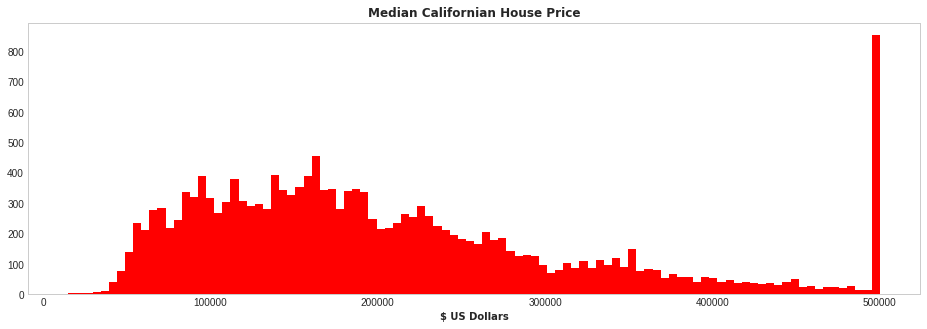

In [ ]:
# Histogram fare plot:

df_train.median_house_value.hist(bins=100, figsize=(16,5), color = "red")
plt.xlabel('$ US Dollars', weight = 'bold', family = 'Arial')
plt.title('Median Californian House Price', weight = 'bold', family = 'Arial')
plt.grid(b=None)

In [ ]:
y = df_train.median_house_value.values + 1e-10
y ### for supervised learning: output vector y

array([ 66900.,  80100.,  85700., ..., 103600.,  85800.,  94600.])

In [ ]:
# List first rows (post-cleaning):

df_train.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.31,34.19,15.0,5612.0,1283.0,1015.0,472.0,1.4936,66900.0
1,-114.47,34.40,19.0,7650.0,1901.0,1129.0,463.0,1.8200,80100.0
2,-114.56,33.69,17.0,720.0,174.0,333.0,117.0,1.6509,85700.0
3,-114.57,33.64,14.0,1501.0,337.0,515.0,226.0,3.1917,73400.0
4,-114.57,33.57,20.0,1454.0,326.0,624.0,262.0,1.9250,65500.0


In [ ]:
X = df_train.drop(['median_house_value'], axis = 1)
X.head() ### for supervised learning: input matrix X

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,-114.31,34.19,15.0,5612.0,1283.0,1015.0,472.0,1.4936
1,-114.47,34.40,19.0,7650.0,1901.0,1129.0,463.0,1.8200
2,-114.56,33.69,17.0,720.0,174.0,333.0,117.0,1.6509
3,-114.57,33.64,14.0,1501.0,337.0,515.0,226.0,3.1917
4,-114.57,33.57,20.0,1454.0,326.0,624.0,262.0,1.9250


In [ ]:
### Optimum rmse: regression model objective function is Root Mean Square Error (RMSE); 
### Should be minimized (as close to zero as possible):

y_global_orig = 0

In [ ]:
### Bayesian Optimization - inputs:

obj_func = 'XGBoost'
n_test = 500 # test points

util_gp = 'CBMinimized'
util_stp = 'tCBMinimized'
n_init = 5 # random initialisations
opt = True

test_perc = 0.90
train_perc = 1 - test_perc

n_test = int(len(df_train) * test_perc)
n_train = int(len(df_train) - n_test)

eps = 1e-08

df = 3

In [ ]:
### Objective function:

if obj_func == 'XGBoost': # 6-D
            
    # Constraints:
    param_lb_alpha = 0
    param_ub_alpha = 10
    
    param_lb_gamma = 0
    param_ub_gamma = 10
    
    param_lb_max_depth = 5
    param_ub_max_depth = 15
    
    param_lb_min_child_weight = 1
    param_ub_min_child_weight = 20
    
    param_lb_subsample = .5
    param_ub_subsample = 1
    
    param_lb_colsample = .1
    param_ub_colsample = 1
    
    # 6-D inputs' parameter bounds:
    param = { 'alpha':  ('cont', (param_lb_alpha, param_ub_alpha)),
         'gamma':  ('cont', (param_lb_gamma, param_ub_gamma)),     
         'max_depth':  ('int', (param_lb_max_depth, param_ub_max_depth)),
         'subsample':  ('cont', (param_lb_subsample, param_ub_subsample)),
          'min_child_weight':  ('int', (param_lb_min_child_weight, param_ub_min_child_weight)),
            'colsample': ('cont', (param_lb_colsample, param_ub_colsample))
        }
       
    # True y bounds:
    dim = 6
    
    max_iter = 30  # iterations of Bayesian optimization
    
    operator = 1 
    
    n_est = 2

In [ ]:
n_start_AcqFunc = max_iter
cov_func = squaredExponential()


In [ ]:
### Set-seeds:

run_num_1 = 1
run_num_2 = 2
run_num_3 = 3
run_num_4 = 4
run_num_5 = 5
run_num_6 = 6
run_num_7 = 7
run_num_8 = 8
run_num_9 = 9
run_num_10 = 10
run_num_11 = 11
run_num_12 = 12
run_num_13 = 13
run_num_14 = 14
run_num_15 = 15
run_num_16 = 16
run_num_17 = 17
run_num_18 = 18
run_num_19 = 19
run_num_20 = 20


In [ ]:
### Cumulative Regret Calculator:

def min_max_array(x):
    new_list = []
    for i, num in enumerate(x):
            new_list.append(np.min(x[0:i+1]))
    return new_list
    

In [ ]:
### Add exact acquisition function gradient as attribute:

Beta_CBM = 1.5 #dim

class Acquisition_new(Acquisition):    
    def __init__(self, mode, eps=1e-06, **params):
        
        self.params = params
        self.eps = eps

        mode_dict = {
            'CBMinimized': self.CBMinimized,
            'tCBMinimized': self.tCBMinimized
        }

        self.f = mode_dict[mode]
   
    def CBMinimized(self, tau, mean, std):
        
        gamma = (mean - y_global_orig - self.eps) / (std + self.eps)
        return (std + self.eps) * (gamma + np.sqrt(Beta_CBM))
    
    def tCBMinimized(self, tau, mean, std, nu=3.0):
        
        gamma = (mean - y_global_orig - self.eps) / (std + self.eps)
        return (std + self.eps) * (gamma + np.sqrt(Beta_CBM))


In [ ]:
start_gp = time.time()
start_gp

1663086027.2050498

In [ ]:
### Bayesian optimization runs (x20): 'gp' Acquisition Function run number = 1

np.random.seed(run_num_1)
surrogate_gp_1 = GaussianProcess(cov_func, optimize=opt)

X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=test_perc, random_state=run_num_1)

def f_syn_polarity1(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_1, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train1, y=y_train1).mean())
    return operator * score

gp_1 = GPGO(surrogate_gp_1, Acquisition_new(util_gp), f_syn_polarity1, param, n_jobs = -1) # define BayesOpt
gp_1.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_gp_1 = gp_1.getResult()[0]
params_gp_1['max_depth'] = int(params_gp_1['max_depth'])
params_gp_1['min_child_weight'] = int(params_gp_1['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_gp_train1 = xgb.DMatrix(X_train1, y_train1)
dX_gp_test1 = xgb.DMatrix(X_test1, y_test1)
model_gp_1 = xgb.train(params_gp_1, dX_gp_train1)
pred_gp_1 = model_gp_1.predict(dX_gp_test1)

rmse_gp_1 = np.sqrt(mean_squared_error(pred_gp_1, y_test1))
rmse_gp_1

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 4.17022005  7.20324493 14.          0.65116629 16.          0.31248008]. 	  -1.9958892406678181 	 -1.927633642985235
init   	 [ 3.96580727  3.87910741 11.          0.96776954  6.          0.71669755]. 	  -1.9397531362536724 	 -1.927633642985235
init   	 [ 2.0445225   8.78117436  7.          0.95698101 10.          0.48762871]. 	  -1.9976238165476006 	 -1.927633642985235
init   	 [ 9.39127789  7.78389236 14.          0.98413079  2.          0.87851823]. 	  -1.927633642985235 	 -1.927633642985235
init   	 [8.29146907 8.29603359 8.         0.58491521 9.         0.18851215]. 	  -1.9902043452530749 	 -1.927633642985235
1      	 [ 7.86951474  0.6406733  11.          0.78919481 19.          0.44182296]. 	  -1.9906604186473822 	 -1.927633642985235
2      	 [3.3802338  7.90980166 8.         0.59612501 4.         0.17409348]. 	  -1.9902505685541254 	 -1.927633642985235
3      	 [ 8.37248824  9.47571383  8.          0.69744113 1

60754.16307826351

In [ ]:
### Bayesian optimization runs (x20): 'gp' Acquisition Function run number = 2

np.random.seed(run_num_2)
surrogate_gp_2 = GaussianProcess(cov_func, optimize=opt)

X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=test_perc, random_state=run_num_2)

def f_syn_polarity2(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_2, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train2, y=y_train2).mean())
    return operator * score

gp_2 = GPGO(surrogate_gp_2, Acquisition_new(util_gp), f_syn_polarity2, param, n_jobs = -1) # define BayesOpt
gp_2.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_gp_2 = gp_2.getResult()[0]
params_gp_2['max_depth'] = int(params_gp_2['max_depth'])
params_gp_2['min_child_weight'] = int(params_gp_2['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_gp_train2 = xgb.DMatrix(X_train2, y_train2)
dX_gp_test2 = xgb.DMatrix(X_test2, y_test2)
model_gp_2 = xgb.train(params_gp_2, dX_gp_train2)
pred_gp_2 = model_gp_2.predict(dX_gp_test2)

rmse_gp_2 = np.sqrt(mean_squared_error(pred_gp_2, y_test2))
rmse_gp_2

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 4.35994902  0.25926232 11.          0.97386531 12.          0.47833102]. 	  -2.0298081650952664 	 -1.9841229044560336
init   	 [ 3.30334821  2.04648634 10.          0.55997527  6.          0.71472339]. 	  -2.0048957563444234 	 -1.9841229044560336
init   	 [ 4.9856117   5.86796978  8.          0.89266757 11.          0.59158659]. 	  -1.9841229044560336 	 -1.9841229044560336
init   	 [ 4.07307832  1.76984624 13.          0.75262305  7.          0.35908193]. 	  -2.0696980515920655 	 -1.9841229044560336
init   	 [ 1.16193318  1.81727038  9.          0.79837265 19.          0.29965165]. 	  -2.061218552452579 	 -1.9841229044560336
1      	 [9.68290573 5.74953535 8.         0.93445831 2.         0.81872709]. 	  -1.9816402148241052 	 -1.9816402148241052
2      	 [ 8.78180153  6.61060882 12.          0.91523653 18.          0.29687212]. 	  -2.0625378531808507 	 -1.9816402148241052
3      	 [ 0.66591974  9.26661294 14.         

60928.26805906831

In [ ]:
### Bayesian optimization runs (x20): 'gp' Acquisition Function run number = 3

np.random.seed(run_num_3)
surrogate_gp_3 = GaussianProcess(cov_func, optimize=opt)

X_train3, X_test3, y_train3, y_test3 = train_test_split(X, y, test_size=test_perc, random_state=run_num_3)

def f_syn_polarity3(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_3, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train3, y=y_train3).mean())
    return operator * score

gp_3 = GPGO(surrogate_gp_3, Acquisition_new(util_gp), f_syn_polarity3, param, n_jobs = -1) # define BayesOpt
gp_3.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_gp_3 = gp_3.getResult()[0]
params_gp_3['max_depth'] = int(params_gp_3['max_depth'])
params_gp_3['min_child_weight'] = int(params_gp_3['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_gp_train3 = xgb.DMatrix(X_train3, y_train3)
dX_gp_test3 = xgb.DMatrix(X_test3, y_test3)
model_gp_3 = xgb.train(params_gp_3, dX_gp_train3)
pred_gp_3 = model_gp_3.predict(dX_gp_test3)

rmse_gp_3 = np.sqrt(mean_squared_error(pred_gp_3, y_test3))
rmse_gp_3

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 5.50797903  7.08147823 13.          0.56066429 11.          0.11687321]. 	  -2.1327354912839973 	 -1.9956488227380944
init   	 [ 0.40630737  2.47888297 11.          0.72040492 13.          0.23083313]. 	  -2.1286878580840187 	 -1.9956488227380944
init   	 [ 4.53172301  2.15577008 11.          0.74631796  2.          0.60296868]. 	  -1.9956488227380944 	 -1.9956488227380944
init   	 [ 2.59252447  4.15101197 13.          0.79330998  8.          0.24118096]. 	  -2.1306652618833883 	 -1.9956488227380944
init   	 [ 5.44649018  7.80314765 10.          0.62879264 18.          0.44917413]. 	  -2.051679716515038 	 -1.9956488227380944
1      	 [1.56262424 9.7795241  5.         0.91450054 5.         0.53102391]. 	  -1.9989939830559114 	 -1.9956488227380944
2      	 [ 8.93142368  1.52910591 13.          0.84039318 17.          0.60846833]. 	  -1.9953686415021132 	 -1.9953686415021132
3      	 [9.68641233 7.7212035  5.         0.6

59850.95807424735

In [ ]:
### Bayesian optimization runs (x20): 'gp' Acquisition Function run number = 4

np.random.seed(run_num_4)
surrogate_gp_4 = GaussianProcess(cov_func, optimize=opt)

X_train4, X_test4, y_train4, y_test4 = train_test_split(X, y, test_size=test_perc, random_state=run_num_4)

def f_syn_polarity4(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_4, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train4, y=y_train4).mean())
    return operator * score

gp_4 = GPGO(surrogate_gp_4, Acquisition_new(util_gp), f_syn_polarity4, param, n_jobs = -1) # define BayesOpt
gp_4.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_gp_4 = gp_4.getResult()[0]
params_gp_4['max_depth'] = int(params_gp_4['max_depth'])
params_gp_4['min_child_weight'] = int(params_gp_4['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_gp_train4 = xgb.DMatrix(X_train4, y_train4)
dX_gp_test4 = xgb.DMatrix(X_test4, y_test4)
model_gp_4 = xgb.train(params_gp_4, dX_gp_train4)
pred_gp_4 = model_gp_4.predict(dX_gp_test4)

rmse_gp_4 = np.sqrt(mean_squared_error(pred_gp_4, y_test4))
rmse_gp_4

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [9.67029839 5.47232249 6.         0.92781047 9.         0.72795594]. 	  -1.9389833982070896 	 -1.9185014978322321
init   	 [ 2.16089496  9.76274455 12.          0.62649118  9.          0.66966679]. 	  -1.9445149590744684 	 -1.9185014978322321
init   	 [ 0.05159149  5.72356491  9.          0.99170034 10.          0.10808749]. 	  -2.1102338527761537 	 -1.9185014978322321
init   	 [ 3.86571283  0.44160058 10.          0.90553105 18.          0.95407958]. 	  -1.9185014978322321 	 -1.9185014978322321
init   	 [ 7.86305986  8.66289299  6.          0.53285477 14.          0.25117497]. 	  -1.9862504726191532 	 -1.9185014978322321
1      	 [ 8.45443649  8.61014312 11.          0.83475494  1.          0.14018305]. 	  -2.1075864515395755 	 -1.9185014978322321
2      	 [ 0.77431146  1.96668116 12.          0.50723361  3.          0.74768925]. 	  -1.9573746201697617 	 -1.9185014978322321
3      	 [2.27858743 6.23199766 5.         0.

61055.818606721616

In [ ]:
### Bayesian optimization runs (x20): 'gp' Acquisition Function run number = 5

np.random.seed(run_num_5)
surrogate_gp_5 = GaussianProcess(cov_func, optimize=opt)

X_train5, X_test5, y_train5, y_test5 = train_test_split(X, y, test_size=test_perc, random_state=run_num_5)

def f_syn_polarity5(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_5, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train5, y=y_train5).mean())
    return operator * score

gp_5 = GPGO(surrogate_gp_5, Acquisition_new(util_gp), f_syn_polarity5, param, n_jobs = -1) # define BayesOpt
gp_5.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_gp_5 = gp_5.getResult()[0]
params_gp_5['max_depth'] = int(params_gp_5['max_depth'])
params_gp_5['min_child_weight'] = int(params_gp_5['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_gp_train5 = xgb.DMatrix(X_train5, y_train5)
dX_gp_test5 = xgb.DMatrix(X_test5, y_test5)
model_gp_5 = xgb.train(params_gp_5, dX_gp_train5)
pred_gp_5 = model_gp_5.predict(dX_gp_test5)

rmse_gp_5 = np.sqrt(mean_squared_error(pred_gp_5, y_test5))
rmse_gp_5

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 2.21993171  8.70732306 11.          0.68186845 10.          0.53957007]. 	  -1.9599422560077813 	 -1.9013654264108653
init   	 [ 6.11743863  7.65907856  5.          0.64840025 16.          0.82745351]. 	  -1.9013654264108653 	 -1.9013654264108653
init   	 [ 6.49458883  8.19472793  6.          0.93996852 19.          0.36647194]. 	  -2.005840325693773 	 -1.9013654264108653
init   	 [ 6.28787909  5.7983781   6.          0.63290956 17.          0.18402673]. 	  -2.0055006279610965 	 -1.9013654264108653
init   	 [8.26554249 8.33492742 9.         0.97900675 3.         0.26957319]. 	  -2.0104758642779474 	 -1.9013654264108653
1      	 [1.95474956 1.21548467 5.         0.65548996 6.         0.3261206 ]. 	  -2.0061716974922197 	 -1.9013654264108653
2      	 [ 0.09956678  5.3014067  14.          0.6298658  17.          0.94976952]. 	  -1.8681155157955736 	 -1.8681155157955736
3      	 [ 8.96005069  0.40158558 13.          0.999

60210.54886703936

In [ ]:
### Bayesian optimization runs (x20): 'gp' Acquisition Function run number = 6

np.random.seed(run_num_6)
surrogate_gp_6 = GaussianProcess(cov_func, optimize=opt)

X_train6, X_test6, y_train6, y_test6 = train_test_split(X, y, test_size=test_perc, random_state=run_num_6)

def f_syn_polarity6(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_6, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train6, y=y_train6).mean())
    return operator * score

gp_6 = GPGO(surrogate_gp_6, Acquisition_new(util_gp), f_syn_polarity6, param, n_jobs = -1) # define BayesOpt
gp_6.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_gp_6 = gp_6.getResult()[0]
params_gp_6['max_depth'] = int(params_gp_6['max_depth'])
params_gp_6['min_child_weight'] = int(params_gp_6['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_gp_train6 = xgb.DMatrix(X_train6, y_train6)
dX_gp_test6 = xgb.DMatrix(X_test6, y_test6)
model_gp_6 = xgb.train(params_gp_6, dX_gp_train6)
pred_gp_6 = model_gp_6.predict(dX_gp_test6)

rmse_gp_6 = np.sqrt(mean_squared_error(pred_gp_6, y_test6))
rmse_gp_6

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [8.92860151 3.31979805 5.         0.99251441 2.         0.57683563]. 	  -2.0905801027256743 	 -2.020381853595591
init   	 [4.18807429 3.35407849 9.         0.87750649 3.         0.56623277]. 	  -2.104747753924113 	 -2.020381853595591
init   	 [ 5.788586    6.45355096 14.          0.70660047 12.          0.82154882]. 	  -2.020381853595591 	 -2.020381853595591
init   	 [4.58184578 6.73834679 5.         0.90108528 3.         0.65482895]. 	  -2.0496910493799936 	 -2.020381853595591
init   	 [ 4.42510505  5.75952352 14.          0.97882365 15.          0.29525604]. 	  -2.1564159616109135 	 -2.020381853595591
1      	 [ 2.61343239  0.80193947  5.          0.83898129 13.          0.84644718]. 	  -2.02621196060558 	 -2.020381853595591
2      	 [ 9.72322443  9.21177696  5.          0.87917074 11.          0.86681736]. 	  -2.0193657462286696 	 -2.0193657462286696
3      	 [ 0.5654966   9.52584762 14.          0.82016688  4.      

60442.43826184427

In [ ]:
### Bayesian optimization runs (x20): 'gp' Acquisition Function run number = 7

np.random.seed(run_num_7)
surrogate_gp_7 = GaussianProcess(cov_func, optimize=opt)

X_train7, X_test7, y_train7, y_test7 = train_test_split(X, y, test_size=test_perc, random_state=run_num_7)

def f_syn_polarity7(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_7, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train7, y=y_train7).mean())
    return operator * score

gp_7 = GPGO(surrogate_gp_7, Acquisition_new(util_gp), f_syn_polarity7, param, n_jobs = -1) # define BayesOpt
gp_7.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_gp_7 = gp_7.getResult()[0]
params_gp_7['max_depth'] = int(params_gp_7['max_depth'])
params_gp_7['min_child_weight'] = int(params_gp_7['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_gp_train7 = xgb.DMatrix(X_train7, y_train7)
dX_gp_test7 = xgb.DMatrix(X_test7, y_test7)
model_gp_7 = xgb.train(params_gp_7, dX_gp_train7)
pred_gp_7 = model_gp_7.predict(dX_gp_test7)

rmse_gp_7 = np.sqrt(mean_squared_error(pred_gp_7, y_test7))
rmse_gp_7

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.76308289 7.79918792 8.         0.98911145 8.         0.98019056]. 	  -1.9078690836840042 	 -1.9078690836840042
init   	 [ 5.3849587   5.01120464 13.          0.74994125  5.          0.88192131]. 	  -1.9193284947185432 	 -1.9078690836840042
init   	 [ 3.30839249  3.9294231  12.          0.6440728  13.          0.41137564]. 	  -1.9707847574302377 	 -1.9078690836840042
init   	 [9.29528191 2.6258377  5.         0.80027446 1.         0.86616513]. 	  -1.955231925484334 	 -1.9078690836840042
init   	 [ 1.74052764  7.90763512 14.          0.7244129   4.          0.77536887]. 	  -1.94667647934123 	 -1.9078690836840042
1      	 [3.70351083 4.59092978 6.         0.70937861 6.         0.814213  ]. 	  -1.9596547112058986 	 -1.9078690836840042
2      	 [ 0.03374059  5.72098042  5.          0.61235924 18.          0.8711559 ]. 	  -1.9589402156911349 	 -1.9078690836840042
3      	 [ 9.12127254  9.64651695 14.          0.53624962  1

61351.93418054509

In [ ]:
### Bayesian optimization runs (x20): 'gp' Acquisition Function run number = 8

np.random.seed(run_num_8)
surrogate_gp_8 = GaussianProcess(cov_func, optimize=opt)

X_train8, X_test8, y_train8, y_test8 = train_test_split(X, y, test_size=test_perc, random_state=run_num_8)

def f_syn_polarity8(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_8, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train8, y=y_train8).mean())
    return operator * score

gp_8 = GPGO(surrogate_gp_8, Acquisition_new(util_gp), f_syn_polarity8, param, n_jobs = -1) # define BayesOpt
gp_8.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_gp_8 = gp_8.getResult()[0]
params_gp_8['max_depth'] = int(params_gp_8['max_depth'])
params_gp_8['min_child_weight'] = int(params_gp_8['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_gp_train8 = xgb.DMatrix(X_train8, y_train8)
dX_gp_test8 = xgb.DMatrix(X_test8, y_test8)
model_gp_8 = xgb.train(params_gp_8, dX_gp_train8)
pred_gp_8 = model_gp_8.predict(dX_gp_test8)

rmse_gp_8 = np.sqrt(mean_squared_error(pred_gp_8, y_test8))
rmse_gp_8

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 8.73429403  9.68540663 10.          0.68875849  9.          0.48011572]. 	  -1.9120326417702995 	 -1.8978279741265411
init   	 [ 6.12033333  7.66062926  8.          0.76133734 13.          0.93379456]. 	  -1.8978279741265411 	 -1.8978279741265411
init   	 [ 1.46524679  7.01527914  7.          0.90913299 10.          0.36016753]. 	  -1.9465178144863287 	 -1.8978279741265411
init   	 [ 9.73855241  3.33774046 14.          0.53290419  7.          0.7088681 ]. 	  -1.921087044254333 	 -1.8978279741265411
init   	 [ 3.00618018  1.82702795 11.          0.75681389 14.          0.98627449]. 	  -1.8997134238136284 	 -1.8978279741265411
1      	 [4.42022545 5.48487111 9.         0.97165909 3.         0.63617522]. 	  -1.8908646806075349 	 -1.8908646806075349
2      	 [ 9.3432851   3.80536023 13.          0.82203895 19.          0.99569116]. 	  -1.89272590205946 	 -1.8908646806075349
3      	 [ 2.52429836  9.02824683 14.          0

60822.98185938519

In [ ]:
### Bayesian optimization runs (x20): 'gp' Acquisition Function run number = 9

np.random.seed(run_num_9)
surrogate_gp_9 = GaussianProcess(cov_func, optimize=opt)

X_train9, X_test9, y_train9, y_test9 = train_test_split(X, y, test_size=test_perc, random_state=run_num_9)

def f_syn_polarity9(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_9, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train9, y=y_train9).mean())
    return operator * score

gp_9 = GPGO(surrogate_gp_9, Acquisition_new(util_gp), f_syn_polarity9, param, n_jobs = -1) # define BayesOpt
gp_9.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_gp_9 = gp_9.getResult()[0]
params_gp_9['max_depth'] = int(params_gp_9['max_depth'])
params_gp_9['min_child_weight'] = int(params_gp_9['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_gp_train9 = xgb.DMatrix(X_train9, y_train9)
dX_gp_test9 = xgb.DMatrix(X_test9, y_test9)
model_gp_9 = xgb.train(params_gp_9, dX_gp_train9)
pred_gp_9 = model_gp_9.predict(dX_gp_test9)

rmse_gp_9 = np.sqrt(mean_squared_error(pred_gp_9, y_test9))
rmse_gp_9

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 0.10374154  5.01874592 11.          0.50377155  2.          0.29670281]. 	  -2.165522561386585 	 -1.963183361033061
init   	 [ 4.18508181  2.48101168 13.          0.69794293  2.          0.25009871]. 	  -2.1585464315559983 	 -1.963183361033061
init   	 [ 8.78559086  9.50964032 13.          0.98395204 11.          0.90820641]. 	  -1.963183361033061 	 -1.963183361033061
init   	 [ 6.66898973  5.47837783  6.          0.97165345 12.          0.72499481]. 	  -2.0332026844846673 	 -1.963183361033061
init   	 [ 8.24870465  4.65668475 13.          0.68760467  9.          0.98502332]. 	  -1.990093015638481 	 -1.963183361033061
1      	 [6.73714319 2.39608167 5.         0.58130302 3.         0.163077  ]. 	  -2.141000706961993 	 -1.963183361033061
2      	 [ 1.89773665  4.24398106 11.          0.60135502  9.          0.22312501]. 	  -2.1420691289307263 	 -1.963183361033061
3      	 [ 3.60566534  9.79805332 11.          0.6203257

60883.36599056475

In [ ]:
### Bayesian optimization runs (x20): 'gp' Acquisition Function run number = 10

np.random.seed(run_num_10)
surrogate_gp_10 = GaussianProcess(cov_func, optimize=opt)

X_train10, X_test10, y_train10, y_test10 = train_test_split(X, y, test_size=test_perc, random_state=run_num_10)

def f_syn_polarity10(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_10, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train10, y=y_train10).mean())
    return operator * score

gp_10 = GPGO(surrogate_gp_10, Acquisition_new(util_gp), f_syn_polarity10, param, n_jobs = -1) # define BayesOpt
gp_10.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_gp_10 = gp_10.getResult()[0]
params_gp_10['max_depth'] = int(params_gp_10['max_depth'])
params_gp_10['min_child_weight'] = int(params_gp_10['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_gp_train10 = xgb.DMatrix(X_train10, y_train10)
dX_gp_test10 = xgb.DMatrix(X_test10, y_test10)
model_gp_10 = xgb.train(params_gp_10, dX_gp_train10)
pred_gp_10 = model_gp_10.predict(dX_gp_test10)

rmse_gp_10 = np.sqrt(mean_squared_error(pred_gp_10, y_test10))
rmse_gp_10

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 7.71320643  0.20751949  5.          0.72150747 17.          0.12265456]. 	  -2.120578178283629 	 -1.940587000655573
init   	 [ 7.0920801   2.65566127 13.          0.57518893 17.          0.83494165]. 	  -1.9492101131384572 	 -1.940587000655573
init   	 [ 3.36071584  8.90816531  6.          0.86087766 15.          0.75469196]. 	  -1.940587000655573 	 -1.940587000655573
init   	 [ 5.40880931  1.31458152  8.          0.57108502 14.          0.62551123]. 	  -1.9531076777438756 	 -1.940587000655573
init   	 [1.82631436 8.26082248 6.         0.80888349 5.         0.15900694]. 	  -2.117914211014308 	 -1.940587000655573
1      	 [8.31989768 3.09778055 7.         0.64798085 3.         0.98471878]. 	  -1.9418208809914852 	 -1.940587000655573
2      	 [ 1.51483713  6.46720195 14.          0.87676044  8.          0.10934204]. 	  -2.1137891529220116 	 -1.940587000655573
3      	 [ 0.44494294  2.20797313 10.          0.76097539  2.

61853.758403879976

In [ ]:
### Bayesian optimization runs (x20): 'gp' Acquisition Function run number = 11

np.random.seed(run_num_11)
surrogate_gp_11 = GaussianProcess(cov_func, optimize=opt)

X_train11, X_test11, y_train11, y_test11 = train_test_split(X, y, test_size=test_perc, random_state=run_num_11)

def f_syn_polarity11(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_11, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train11, y=y_train11).mean())
    return operator * score

gp_11 = GPGO(surrogate_gp_11, Acquisition_new(util_gp), f_syn_polarity11, param, n_jobs = -1) # define BayesOpt
gp_11.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_gp_11 = gp_11.getResult()[0]
params_gp_11['max_depth'] = int(params_gp_11['max_depth'])
params_gp_11['min_child_weight'] = int(params_gp_11['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_gp_train11 = xgb.DMatrix(X_train11, y_train11)
dX_gp_test11 = xgb.DMatrix(X_test11, y_test11)
model_gp_11 = xgb.train(params_gp_11, dX_gp_train11)
pred_gp_11 = model_gp_11.predict(dX_gp_test11)

rmse_gp_11 = np.sqrt(mean_squared_error(pred_gp_11, y_test11))
rmse_gp_11

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 1.80269689  0.19475241  6.          0.59705781 13.          0.47818324]. 	  -1.9015016338784072 	 -1.8483088481664438
init   	 [ 4.85427098  0.12780815  5.          0.91309068 14.          0.86571558]. 	  -1.8541246115708696 	 -1.8483088481664438
init   	 [ 7.2996447   1.08736072 10.          0.92857712 18.          0.66910061]. 	  -1.8532385782615584 	 -1.8483088481664438
init   	 [ 0.20483613  1.16737269  7.          0.57895615 16.          0.83644782]. 	  -1.8483088481664438 	 -1.8483088481664438
init   	 [ 3.44624491  3.18798797 14.          0.54197657 15.          0.63958906]. 	  -1.8544028395211494 	 -1.8483088481664438
1      	 [9.77136617 6.6548802  7.         0.51036649 9.         0.81011527]. 	  -1.857805309121489 	 -1.8483088481664438
2      	 [0.5279662  8.15331655 5.         0.83127487 9.         0.53242685]. 	  -1.8583090737384367 	 -1.8483088481664438
3      	 [8.62555756 1.5478147  8.         0.9996446

62120.738966925026

In [ ]:
### Bayesian optimization runs (x20): 'gp' Acquisition Function run number = 12

np.random.seed(run_num_12)
surrogate_gp_12 = GaussianProcess(cov_func, optimize=opt)

X_train12, X_test12, y_train12, y_test12 = train_test_split(X, y, test_size=test_perc, random_state=run_num_12)

def f_syn_polarity12(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_12, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train12, y=y_train12).mean())
    return operator * score

gp_12 = GPGO(surrogate_gp_12, Acquisition_new(util_gp), f_syn_polarity12, param, n_jobs = -1) # define BayesOpt
gp_12.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_gp_12 = gp_12.getResult()[0]
params_gp_12['max_depth'] = int(params_gp_12['max_depth'])
params_gp_12['min_child_weight'] = int(params_gp_12['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_gp_train12 = xgb.DMatrix(X_train12, y_train12)
dX_gp_test12 = xgb.DMatrix(X_test12, y_test12)
model_gp_12 = xgb.train(params_gp_12, dX_gp_train12)
pred_gp_12 = model_gp_12.predict(dX_gp_test12)

rmse_gp_12 = np.sqrt(mean_squared_error(pred_gp_12, y_test12))
rmse_gp_12

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [1.54162842 7.40049697 6.         0.54321714 4.         0.11311747]. 	  -2.1334526770789597 	 -2.024051333725814
init   	 [ 9.18747008  9.00714854 14.          0.97847467 11.          0.35544552]. 	  -2.1193628264859967 	 -2.024051333725814
init   	 [ 6.06083184  9.44225136 14.          0.95626942  5.          0.56910342]. 	  -2.0441668248397766 	 -2.024051333725814
init   	 [ 5.52037633  4.85377414  7.          0.97886436 17.          0.78810441]. 	  -2.024051333725814 	 -2.024051333725814
init   	 [ 0.20809798  1.35210178  5.          0.65494879 16.          0.36062811]. 	  -2.1361168864432996 	 -2.024051333725814
1      	 [8.63751826 0.13862581 5.         0.68795787 5.         0.56136101]. 	  -2.0796638469522035 	 -2.024051333725814
2      	 [9.04256367 2.61736915 8.         0.66026854 8.         0.14510453]. 	  -2.131446620940571 	 -2.024051333725814
3      	 [ 6.53994588  2.3076831  14.          0.85412016 14.     

62561.0199556965

In [ ]:
### Bayesian optimization runs (x20): 'gp' Acquisition Function run number = 13

np.random.seed(run_num_13)
surrogate_gp_13 = GaussianProcess(cov_func, optimize=opt)

X_train13, X_test13, y_train13, y_test13 = train_test_split(X, y, test_size=test_perc, random_state=run_num_13)

def f_syn_polarity13(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_13, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train13, y=y_train13).mean())
    return operator * score

gp_13 = GPGO(surrogate_gp_13, Acquisition_new(util_gp), f_syn_polarity13, param, n_jobs = -1) # define BayesOpt
gp_13.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_gp_13 = gp_13.getResult()[0]
params_gp_13['max_depth'] = int(params_gp_13['max_depth'])
params_gp_13['min_child_weight'] = int(params_gp_13['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_gp_train13 = xgb.DMatrix(X_train13, y_train13)
dX_gp_test13 = xgb.DMatrix(X_test13, y_test13)
model_gp_13 = xgb.train(params_gp_13, dX_gp_train13)
pred_gp_13 = model_gp_13.predict(dX_gp_test13)

rmse_gp_13 = np.sqrt(mean_squared_error(pred_gp_13, y_test13))
rmse_gp_13

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 7.77702411  2.3754122  11.          0.94649135 13.          0.7827256 ]. 	  -1.9378879688573776 	 -1.9378879688573776
init   	 [ 7.51661514  6.07343344 11.          0.69402149 11.          0.13153287]. 	  -2.1281814260438034 	 -1.9378879688573776
init   	 [ 2.98449471  0.58512492 10.          0.73579614 12.          0.33065195]. 	  -2.035439141741416 	 -1.9378879688573776
init   	 [ 3.47581215  0.0941277  11.          0.86143432  8.          0.58454932]. 	  -1.9849077466482243 	 -1.9378879688573776
init   	 [ 4.70137857  6.24432527 10.          0.8149145  18.          0.10784416]. 	  -2.129754084431454 	 -1.9378879688573776
1      	 [1.51786663 9.25994479 9.         0.99792981 2.         0.61199673]. 	  -1.9877621530540666 	 -1.9378879688573776
2      	 [ 8.98888343  8.3187307  12.          0.8674744   2.          0.79321204]. 	  -1.9449521808507277 	 -1.9378879688573776
3      	 [ 2.15576965  9.94171254  5.          

60649.53896388737

In [ ]:
### Bayesian optimization runs (x20): 'gp' Acquisition Function run number = 14

np.random.seed(run_num_14)
surrogate_gp_14 = GaussianProcess(cov_func, optimize=opt)

X_train14, X_test14, y_train14, y_test14 = train_test_split(X, y, test_size=test_perc, random_state=run_num_14)

def f_syn_polarity14(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_14, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train14, y=y_train14).mean())
    return operator * score

gp_14 = GPGO(surrogate_gp_14, Acquisition_new(util_gp), f_syn_polarity14, param, n_jobs = -1) # define BayesOpt
gp_14.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_gp_14 = gp_14.getResult()[0]
params_gp_14['max_depth'] = int(params_gp_14['max_depth'])
params_gp_14['min_child_weight'] = int(params_gp_14['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_gp_train14 = xgb.DMatrix(X_train14, y_train14)
dX_gp_test14 = xgb.DMatrix(X_test14, y_test14)
model_gp_14 = xgb.train(params_gp_14, dX_gp_train14)
pred_gp_14 = model_gp_14.predict(dX_gp_test14)

rmse_gp_14 = np.sqrt(mean_squared_error(pred_gp_14, y_test14))
rmse_gp_14

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 5.13943344  7.73165052 12.          0.6831412  11.          0.37876233]. 	  -2.0164943249949188 	 -1.9500125911148154
init   	 [ 9.57603739  5.13116712 14.          0.76959997 12.          0.71328228]. 	  -1.9699703337255101 	 -1.9500125911148154
init   	 [5.34950319 2.47493539 5.         0.50293689 6.         0.29706373]. 	  -2.0377420945059783 	 -1.9500125911148154
init   	 [ 2.94506579  3.45329697  8.          0.87620946 14.          0.9783044 ]. 	  -1.9500125911148154 	 -1.9500125911148154
init   	 [ 1.11811929  1.73004086  5.          0.73745288 12.          0.20586008]. 	  -2.0557846580952273 	 -1.9500125911148154
1      	 [ 6.50637223  2.67617722 14.          0.53562507  1.          0.16862152]. 	  -2.065483651943695 	 -1.9500125911148154
2      	 [ 9.22243919  0.59642165  6.          0.72537748 19.          0.46639325]. 	  -2.0211824238378755 	 -1.9500125911148154
3      	 [ 5.79577795  1.8570688  14.         

60569.1703919756

In [ ]:
### Bayesian optimization runs (x20): 'gp' Acquisition Function run number = 15

np.random.seed(run_num_15)
surrogate_gp_15 = GaussianProcess(cov_func, optimize=opt)

X_train15, X_test15, y_train15, y_test15 = train_test_split(X, y, test_size=test_perc, random_state=run_num_15)

def f_syn_polarity15(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_15, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train15, y=y_train15).mean())
    return operator * score

gp_15 = GPGO(surrogate_gp_15, Acquisition_new(util_gp), f_syn_polarity15, param, n_jobs = -1) # define BayesOpt
gp_15.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_gp_15 = gp_15.getResult()[0]
params_gp_15['max_depth'] = int(params_gp_15['max_depth'])
params_gp_15['min_child_weight'] = int(params_gp_15['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_gp_train15 = xgb.DMatrix(X_train15, y_train15)
dX_gp_test15 = xgb.DMatrix(X_test15, y_test15)
model_gp_15 = xgb.train(params_gp_15, dX_gp_train15)
pred_gp_15 = model_gp_15.predict(dX_gp_test15)

rmse_gp_15 = np.sqrt(mean_squared_error(pred_gp_15, y_test15))
rmse_gp_15

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 8.48817697  1.78895925 12.          0.55549316  8.          0.93397854]. 	  -1.9771020004296471 	 -1.9771020004296471
init   	 [ 0.24953032  8.22298097 12.          0.62494951 11.          0.12924598]. 	  -2.039987754752231 	 -1.9771020004296471
init   	 [ 5.02017228  5.50882771 11.          0.85295832 19.          0.13548008]. 	  -2.0342163062344127 	 -1.9771020004296471
init   	 [2.0023081  9.98543403 7.         0.6295772  2.         0.526127  ]. 	  -1.9991206593771125 	 -1.9771020004296471
init   	 [ 5.09715306  9.45038417 11.          0.7388277  16.          0.22739973]. 	  -2.0362669401948086 	 -1.9771020004296471
1      	 [ 0.29158961  4.9949242  12.          0.89124583  3.          0.67554049]. 	  -1.9851996507567322 	 -1.9771020004296471
2      	 [ 0.67158936  0.34278237  6.          0.51048023 11.          0.77715736]. 	  -2.003673551363784 	 -1.9771020004296471
3      	 [9.75991344 6.15203198 6.         0.65

60398.20672941871

In [ ]:
### Bayesian optimization runs (x20): 'gp' Acquisition Function run number = 16

np.random.seed(run_num_16)
surrogate_gp_16 = GaussianProcess(cov_func, optimize=opt)

X_train16, X_test16, y_train16, y_test16 = train_test_split(X, y, test_size=test_perc, random_state=run_num_16)

def f_syn_polarity16(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_16, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train16, y=y_train16).mean())
    return operator * score

gp_16 = GPGO(surrogate_gp_16, Acquisition_new(util_gp), f_syn_polarity16, param, n_jobs = -1) # define BayesOpt
gp_16.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_gp_16 = gp_16.getResult()[0]
params_gp_16['max_depth'] = int(params_gp_16['max_depth'])
params_gp_16['min_child_weight'] = int(params_gp_16['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_gp_train16 = xgb.DMatrix(X_train16, y_train16)
dX_gp_test16 = xgb.DMatrix(X_test16, y_test16)
model_gp_16 = xgb.train(params_gp_16, dX_gp_train16)
pred_gp_16 = model_gp_16.predict(dX_gp_test16)

rmse_gp_16 = np.sqrt(mean_squared_error(pred_gp_16, y_test16))
rmse_gp_16

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [2.23291079 5.23163341 6.         0.65430839 5.         0.30077285]. 	  -2.0565156149305297 	 -2.035211151920518
init   	 [6.88726162 1.63731425 7.         0.97050543 2.         0.25392012]. 	  -2.055048050691712 	 -2.035211151920518
init   	 [ 5.94328983  5.6393473   5.          0.67602695 19.          0.42538144]. 	  -2.035211151920518 	 -2.035211151920518
init   	 [ 0.88741148  3.08148142 14.          0.56043938  9.          0.27515386]. 	  -2.0784041797925226 	 -2.035211151920518
init   	 [ 2.74631586  1.30996118 11.          0.52160786  8.          0.27956463]. 	  -2.070688794097313 	 -2.035211151920518
1      	 [ 7.8937256   1.5972923  14.          0.61610774 17.          0.78739284]. 	  -1.9211628477361509 	 -1.9211628477361509
2      	 [ 9.01655783  8.21383177  9.          0.60772965 10.          0.9401803 ]. 	  -1.8833303967241242 	 -1.8833303967241242
3      	 [ 4.35132073  9.89698316 12.          0.94137984 1

63530.395622310556

In [ ]:
### Bayesian optimization runs (x20): 'gp' Acquisition Function run number = 17

np.random.seed(run_num_17)
surrogate_gp_17 = GaussianProcess(cov_func, optimize=opt)

X_train17, X_test17, y_train17, y_test17 = train_test_split(X, y, test_size=test_perc, random_state=run_num_17)

def f_syn_polarity17(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_17, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train17, y=y_train17).mean())
    return operator * score

gp_17 = GPGO(surrogate_gp_17, Acquisition_new(util_gp), f_syn_polarity17, param, n_jobs = -1) # define BayesOpt
gp_17.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_gp_17 = gp_17.getResult()[0]
params_gp_17['max_depth'] = int(params_gp_17['max_depth'])
params_gp_17['min_child_weight'] = int(params_gp_17['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_gp_train17 = xgb.DMatrix(X_train17, y_train17)
dX_gp_test17 = xgb.DMatrix(X_test17, y_test17)
model_gp_17 = xgb.train(params_gp_17, dX_gp_train17)
pred_gp_17 = model_gp_17.predict(dX_gp_test17)

rmse_gp_17 = np.sqrt(mean_squared_error(pred_gp_17, y_test17))
rmse_gp_17

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 2.94665003  5.30586756 11.          0.94443241 14.          0.80828691]. 	  -2.0339055477365475 	 -2.0339055477365475
init   	 [ 6.56333522  6.37520896 12.          0.81487881 18.          0.42203224]. 	  -2.0931879884342264 	 -2.0339055477365475
init   	 [ 9.45683187  0.6004468  11.          0.5171566  10.          0.53881211]. 	  -2.0781263774021443 	 -2.0339055477365475
init   	 [2.72705857 1.19063434 6.         0.74176431 6.         0.10101151]. 	  -2.1016571617786393 	 -2.0339055477365475
init   	 [ 4.77631812  5.24671297 13.          0.66254476 19.          0.36708086]. 	  -2.0994481639151874 	 -2.0339055477365475
1      	 [ 0.65702322  5.79284078 13.          0.75136902  1.          0.30306068]. 	  -2.1101246565070526 	 -2.0339055477365475
2      	 [ 6.93446178  8.68032298 13.          0.78195789  7.          0.91906958]. 	  -1.9718672938390385 	 -1.9718672938390385
3      	 [9.72843652 3.88893279 9.         0.

60093.9507643081

In [ ]:
### Bayesian optimization runs (x20): 'gp' Acquisition Function run number = 18

np.random.seed(run_num_18)
surrogate_gp_18 = GaussianProcess(cov_func, optimize=opt)

X_train18, X_test18, y_train18, y_test18 = train_test_split(X, y, test_size=test_perc, random_state=run_num_18)

def f_syn_polarity18(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_11, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train18, y=y_train18).mean())
    return operator * score

gp_18 = GPGO(surrogate_gp_18, Acquisition_new(util_gp), f_syn_polarity18, param, n_jobs = -1) # define BayesOpt
gp_18.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_gp_18 = gp_18.getResult()[0]
params_gp_18['max_depth'] = int(params_gp_18['max_depth'])
params_gp_18['min_child_weight'] = int(params_gp_18['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_gp_train18 = xgb.DMatrix(X_train18, y_train18)
dX_gp_test18 = xgb.DMatrix(X_test18, y_test18)
model_gp_18 = xgb.train(params_gp_18, dX_gp_train18)
pred_gp_18 = model_gp_18.predict(dX_gp_test18)

rmse_gp_18 = np.sqrt(mean_squared_error(pred_gp_18, y_test18))
rmse_gp_18

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [6.50374242 5.05453374 6.         0.59092011 3.         0.28357516]. 	  -2.124076612902688 	 -1.9684597267146717
init   	 [0.11506734 4.26891483 9.         0.81785956 5.         0.63489043]. 	  -1.970130070404765 	 -1.9684597267146717
init   	 [ 2.8861259   6.35547834 11.          0.64267955 14.          0.27877092]. 	  -2.1124427977128897 	 -1.9684597267146717
init   	 [6.57189031 6.99655629 8.         0.63235896 4.         0.52894035]. 	  -1.9684597267146717 	 -1.9684597267146717
init   	 [ 6.66600348  2.11312037 14.          0.74363461  4.          0.73174558]. 	  -1.9716784325247372 	 -1.9684597267146717
1      	 [ 8.67093232  0.11649132  5.          0.92962202 15.          0.53672863]. 	  -1.9671214996935293 	 -1.9671214996935293
2      	 [ 8.43851229  2.41114508 13.          0.75771586 19.          0.86905071]. 	  -1.9575740050743662 	 -1.9575740050743662
3      	 [ 9.44281001  9.01534322  7.          0.99142432 1

60711.75357387342

In [ ]:
### Bayesian optimization runs (x20): 'gp' Acquisition Function run number = 19

np.random.seed(run_num_19)
surrogate_gp_19 = GaussianProcess(cov_func, optimize=opt)

X_train19, X_test19, y_train19, y_test19 = train_test_split(X, y, test_size=test_perc, random_state=run_num_19)

def f_syn_polarity19(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_19, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train19, y=y_train19).mean())
    return operator * score

gp_19 = GPGO(surrogate_gp_19, Acquisition_new(util_gp), f_syn_polarity19, param, n_jobs = -1) # define BayesOpt
gp_19.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_gp_19 = gp_19.getResult()[0]
params_gp_19['max_depth'] = int(params_gp_19['max_depth'])
params_gp_19['min_child_weight'] = int(params_gp_19['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_gp_train19 = xgb.DMatrix(X_train19, y_train19)
dX_gp_test19 = xgb.DMatrix(X_test19, y_test19)
model_gp_19 = xgb.train(params_gp_19, dX_gp_train19)
pred_gp_19 = model_gp_19.predict(dX_gp_test19)

rmse_gp_19 = np.sqrt(mean_squared_error(pred_gp_19, y_test19))
rmse_gp_19

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 0.97533602  7.61249717 13.          0.85765469 11.          0.39830191]. 	  -2.1125055225907645 	 -2.0304436386765667
init   	 [ 0.82999565  6.71977081  6.          0.50407413 19.          0.67209466]. 	  -2.1089329254044453 	 -2.0304436386765667
init   	 [ 2.15923256  5.49027432 12.          0.52588686 10.          0.20235326]. 	  -2.2159557105709857 	 -2.0304436386765667
init   	 [4.99659267 1.52108422 6.         0.73481085 4.         0.71949465]. 	  -2.0952304096019114 	 -2.0304436386765667
init   	 [ 3.72927156  9.46160045  5.          0.80554614 18.          0.97708466]. 	  -2.0304436386765667 	 -2.0304436386765667
1      	 [ 8.33060043  1.42030563  8.          0.92863724 14.          0.78606141]. 	  -2.0145894949098326 	 -2.0145894949098326
2      	 [ 4.70068371  4.9755295  14.          0.98901029  1.          0.96039614]. 	  -2.013402847080974 	 -2.013402847080974
3      	 [9.07948237 9.55063617 7.         0.80

63297.06051753857

In [ ]:
### Bayesian optimization runs (x20): 'gp' Acquisition Function run number = 20

np.random.seed(run_num_20)
surrogate_gp_20 = GaussianProcess(cov_func, optimize=opt)

X_train20, X_test20, y_train20, y_test20 = train_test_split(X, y, test_size=test_perc, random_state=run_num_20)

def f_syn_polarity20(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_20, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train20, y=y_train20).mean())
    return operator * score

gp_20 = GPGO(surrogate_gp_20, Acquisition_new(util_gp), f_syn_polarity20, param, n_jobs = -1) # define BayesOpt
gp_20.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_gp_20 = gp_20.getResult()[0]
params_gp_20['max_depth'] = int(params_gp_20['max_depth'])
params_gp_20['min_child_weight'] = int(params_gp_20['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_gp_train20 = xgb.DMatrix(X_train20, y_train20)
dX_gp_test20 = xgb.DMatrix(X_test20, y_test20)
model_gp_20 = xgb.train(params_gp_20, dX_gp_train20)
pred_gp_20 = model_gp_20.predict(dX_gp_test20)

rmse_gp_20 = np.sqrt(mean_squared_error(pred_gp_20, y_test20))
rmse_gp_20

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 5.88130801  8.97713728 14.          0.81074445  8.          0.95540649]. 	  -1.909363007310379 	 -1.909363007310379
init   	 [6.72865655 0.41173329 8.         0.6361582  7.         0.76174061]. 	  -1.945489761868388 	 -1.909363007310379
init   	 [ 4.77387703  8.66202323 10.          0.51833215  7.          0.10123387]. 	  -2.0538318450351323 	 -1.909363007310379
init   	 [ 5.75489985  4.74524381  8.          0.78084343 15.          0.26643049]. 	  -2.019385891619828 	 -1.909363007310379
init   	 [ 4.53444     4.47342833  8.          0.91974896 18.          0.35997552]. 	  -2.0147074022409646 	 -1.909363007310379
1      	 [ 7.96566073  7.15509535  7.          0.79906691 11.          0.34132075]. 	  -2.0240306652522984 	 -1.909363007310379
2      	 [ 1.98667885  1.35773177 13.          0.57199118  2.          0.39498908]. 	  -2.0408843487652284 	 -1.909363007310379
3      	 [ 0.05406024  0.42106765 14.          0.606636

59194.599001987306

In [ ]:
end_gp = time.time()
end_gp

time_gp = end_gp - start_gp
time_gp

start_stp = time.time()
start_stp

1663087124.2799814

In [ ]:
### Bayesian optimization runs (x20): 'stp' Acquisition Function run number = 1 

np.random.seed(run_num_1)
surrogate_stp_1 = tStudentProcess(cov_func, optimize=opt, nu = df)

X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=test_perc, random_state=run_num_1)

def f_syn_polarity1(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_1, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train1, y=y_train1).mean())
    return operator * score

stp_1 = GPGO(surrogate_stp_1, Acquisition_new(util_stp), f_syn_polarity1, param, n_jobs = -1) # Define BayesOpt
stp_1.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_stp_1 = stp_1.getResult()[0]
params_stp_1['max_depth'] = int(params_stp_1['max_depth'])
params_stp_1['min_child_weight'] = int(params_stp_1['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_stp_train1 = xgb.DMatrix(X_train1, y_train1)
dX_stp_test1 = xgb.DMatrix(X_test1, y_test1)
model_stp_1 = xgb.train(params_stp_1, dX_stp_train1)
pred_stp_1 = model_stp_1.predict(dX_stp_test1)

rmse_stp_1 = np.sqrt(mean_squared_error(pred_stp_1, y_test1))
rmse_stp_1

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 4.17022005  7.20324493 14.          0.65116629 16.          0.31248008]. 	  -1.9958892406678181 	 -1.927633642985235
init   	 [ 3.96580727  3.87910741 11.          0.96776954  6.          0.71669755]. 	  -1.9397531362536724 	 -1.927633642985235
init   	 [ 2.0445225   8.78117436  7.          0.95698101 10.          0.48762871]. 	  -1.9976238165476006 	 -1.927633642985235
init   	 [ 9.39127789  7.78389236 14.          0.98413079  2.          0.87851823]. 	  -1.927633642985235 	 -1.927633642985235
init   	 [8.29146907 8.29603359 8.         0.58491521 9.         0.18851215]. 	  -1.9902043452530749 	 -1.927633642985235
1      	 [ 6.16328945  0.35999436  5.          0.50627799 18.          0.9705487 ]. 	  -1.9418408349605791 	 -1.927633642985235
2      	 [ 3.06550626  9.28266952  7.          0.97265422 12.          0.93288355]. 	  -1.9149795339973708 	 -1.9149795339973708
3      	 [ 9.9482187   2.21666862 14.          0.708

61032.19618864838

In [ ]:
### Bayesian optimization runs (x20): 'stp' Acquisition Function run number = 2 

np.random.seed(run_num_2)
surrogate_stp_2 = tStudentProcess(cov_func, optimize=opt, nu = df)

X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=test_perc, random_state=run_num_2)

def f_syn_polarity2(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_2, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train2, y=y_train2).mean())
    return operator * score

stp_2 = GPGO(surrogate_stp_2, Acquisition_new(util_stp), f_syn_polarity2, param, n_jobs = -1) # Define BayesOpt
stp_2.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_stp_2 = stp_2.getResult()[0]
params_stp_2['max_depth'] = int(params_stp_2['max_depth'])
params_stp_2['min_child_weight'] = int(params_stp_2['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_stp_train2 = xgb.DMatrix(X_train2, y_train2)
dX_stp_test2 = xgb.DMatrix(X_test2, y_test2)
model_stp_2 = xgb.train(params_stp_2, dX_stp_train2)
pred_stp_2 = model_stp_2.predict(dX_stp_test2)

rmse_stp_2 = np.sqrt(mean_squared_error(pred_stp_2, y_test2))
rmse_stp_2

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 4.35994902  0.25926232 11.          0.97386531 12.          0.47833102]. 	  -2.0298081650952664 	 -1.9841229044560336
init   	 [ 3.30334821  2.04648634 10.          0.55997527  6.          0.71472339]. 	  -2.0048957563444234 	 -1.9841229044560336
init   	 [ 4.9856117   5.86796978  8.          0.89266757 11.          0.59158659]. 	  -1.9841229044560336 	 -1.9841229044560336
init   	 [ 4.07307832  1.76984624 13.          0.75262305  7.          0.35908193]. 	  -2.0696980515920655 	 -1.9841229044560336
init   	 [ 1.16193318  1.81727038  9.          0.79837265 19.          0.29965165]. 	  -2.061218552452579 	 -1.9841229044560336
1      	 [9.68290573 5.74953535 8.         0.93445831 2.         0.81872709]. 	  -1.9816402148241052 	 -1.9816402148241052
2      	 [ 8.78180153  6.61060882 12.          0.91523653 18.          0.29687212]. 	  -2.0625378531808507 	 -1.9816402148241052
3      	 [ 0.66591974  9.26661294 14.         

60928.26805906831

In [ ]:
### Bayesian optimization runs (x20): 'stp' Acquisition Function run number = 3 

np.random.seed(run_num_3)
surrogate_stp_3 = tStudentProcess(cov_func, optimize=opt, nu = df)

X_train3, X_test3, y_train3, y_test3 = train_test_split(X, y, test_size=test_perc, random_state=run_num_3)

def f_syn_polarity3(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_3, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train3, y=y_train3).mean())
    return operator * score

stp_3 = GPGO(surrogate_stp_3, Acquisition_new(util_stp), f_syn_polarity3, param, n_jobs = -1) # Define BayesOpt
stp_3.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_stp_3 = stp_3.getResult()[0]
params_stp_3['max_depth'] = int(params_stp_3['max_depth'])
params_stp_3['min_child_weight'] = int(params_stp_3['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_stp_train3 = xgb.DMatrix(X_train3, y_train3)
dX_stp_test3 = xgb.DMatrix(X_test3, y_test3)
model_stp_3 = xgb.train(params_stp_3, dX_stp_train3)
pred_stp_3 = model_stp_3.predict(dX_stp_test3)

rmse_stp_3 = np.sqrt(mean_squared_error(pred_stp_3, y_test3))
rmse_stp_3

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 5.50797903  7.08147823 13.          0.56066429 11.          0.11687321]. 	  -2.1327354912839973 	 -1.9956488227380944
init   	 [ 0.40630737  2.47888297 11.          0.72040492 13.          0.23083313]. 	  -2.1286878580840187 	 -1.9956488227380944
init   	 [ 4.53172301  2.15577008 11.          0.74631796  2.          0.60296868]. 	  -1.9956488227380944 	 -1.9956488227380944
init   	 [ 2.59252447  4.15101197 13.          0.79330998  8.          0.24118096]. 	  -2.1306652618833883 	 -1.9956488227380944
init   	 [ 5.44649018  7.80314765 10.          0.62879264 18.          0.44917413]. 	  -2.051679716515038 	 -1.9956488227380944
1      	 [4.88873245 9.27936348 6.         0.94344906 8.         0.25949204]. 	  -2.0788458529169214 	 -1.9956488227380944
2      	 [ 8.93142368  1.52910591 13.          0.84039318 17.          0.60846833]. 	  -1.9953686415021132 	 -1.9953686415021132
3      	 [ 6.38594331  1.19109066  5.         

61917.93931192609

In [ ]:
### Bayesian optimization runs (x20): 'stp' Acquisition Function run number = 4 

np.random.seed(run_num_4)
surrogate_stp_4 = tStudentProcess(cov_func, optimize=opt, nu = df)

X_train4, X_test4, y_train4, y_test4 = train_test_split(X, y, test_size=test_perc, random_state=run_num_4)

def f_syn_polarity4(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_4, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train4, y=y_train4).mean())
    return operator * score

stp_4 = GPGO(surrogate_stp_4, Acquisition_new(util_stp), f_syn_polarity4, param, n_jobs = -1) # Define BayesOpt
stp_4.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_stp_4 = stp_4.getResult()[0]
params_stp_4['max_depth'] = int(params_stp_4['max_depth'])
params_stp_4['min_child_weight'] = int(params_stp_4['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_stp_train4 = xgb.DMatrix(X_train4, y_train4)
dX_stp_test4 = xgb.DMatrix(X_test4, y_test4)
model_stp_4 = xgb.train(params_stp_4, dX_stp_train4)
pred_stp_4 = model_stp_4.predict(dX_stp_test4)

rmse_stp_4 = np.sqrt(mean_squared_error(pred_stp_4, y_test4))
rmse_stp_4

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [9.67029839 5.47232249 6.         0.92781047 9.         0.72795594]. 	  -1.9389833982070896 	 -1.9185014978322321
init   	 [ 2.16089496  9.76274455 12.          0.62649118  9.          0.66966679]. 	  -1.9445149590744684 	 -1.9185014978322321
init   	 [ 0.05159149  5.72356491  9.          0.99170034 10.          0.10808749]. 	  -2.1102338527761537 	 -1.9185014978322321
init   	 [ 3.86571283  0.44160058 10.          0.90553105 18.          0.95407958]. 	  -1.9185014978322321 	 -1.9185014978322321
init   	 [ 7.86305986  8.66289299  6.          0.53285477 14.          0.25117497]. 	  -1.9862504726191532 	 -1.9185014978322321
1      	 [ 8.45443649  8.61014312 11.          0.83475494  1.          0.14018305]. 	  -2.1075864515395755 	 -1.9185014978322321
2      	 [ 0.77431146  1.96668116 12.          0.50723361  3.          0.74768925]. 	  -1.9573746201697617 	 -1.9185014978322321
3      	 [2.27858743 6.23199766 5.         0.

60684.47557007898

In [ ]:
### Bayesian optimization runs (x20): 'stp' Acquisition Function run number = 5 

np.random.seed(run_num_5)
surrogate_stp_5 = tStudentProcess(cov_func, optimize=opt, nu = df)

X_train5, X_test5, y_train5, y_test5 = train_test_split(X, y, test_size=test_perc, random_state=run_num_5)

def f_syn_polarity5(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_5, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train5, y=y_train5).mean())
    return operator * score

stp_5 = GPGO(surrogate_stp_5, Acquisition_new(util_stp), f_syn_polarity5, param, n_jobs = -1) # Define BayesOpt
stp_5.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_stp_5 = stp_5.getResult()[0]
params_stp_5['max_depth'] = int(params_stp_5['max_depth'])
params_stp_5['min_child_weight'] = int(params_stp_5['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_stp_train5 = xgb.DMatrix(X_train5, y_train5)
dX_stp_test5 = xgb.DMatrix(X_test5, y_test5)
model_stp_5 = xgb.train(params_stp_5, dX_stp_train5)
pred_stp_5 = model_stp_5.predict(dX_stp_test5)

rmse_stp_5 = np.sqrt(mean_squared_error(pred_stp_5, y_test5))
rmse_stp_5

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 2.21993171  8.70732306 11.          0.68186845 10.          0.53957007]. 	  -1.9599422560077813 	 -1.9013654264108653
init   	 [ 6.11743863  7.65907856  5.          0.64840025 16.          0.82745351]. 	  -1.9013654264108653 	 -1.9013654264108653
init   	 [ 6.49458883  8.19472793  6.          0.93996852 19.          0.36647194]. 	  -2.005840325693773 	 -1.9013654264108653
init   	 [ 6.28787909  5.7983781   6.          0.63290956 17.          0.18402673]. 	  -2.0055006279610965 	 -1.9013654264108653
init   	 [8.26554249 8.33492742 9.         0.97900675 3.         0.26957319]. 	  -2.0104758642779474 	 -1.9013654264108653
1      	 [1.95474956 1.21548467 5.         0.65548996 6.         0.3261206 ]. 	  -2.0061716974922197 	 -1.9013654264108653
2      	 [ 0.09956678  5.3014067  14.          0.6298658  17.          0.94976952]. 	  -1.8681155157955736 	 -1.8681155157955736
3      	 [ 8.96005069  0.40158558 13.          0.999

61776.60439291778

In [ ]:
### Bayesian optimization runs (x20): 'stp' Acquisition Function run number = 6 

np.random.seed(run_num_6)
surrogate_stp_6 = tStudentProcess(cov_func, optimize=opt, nu = df)

X_train6, X_test6, y_train6, y_test6 = train_test_split(X, y, test_size=test_perc, random_state=run_num_6)

def f_syn_polarity6(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=int(min_child_weight),
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_6, objective = 'reg:squarederror', eval_metric = 'rmse')
    score = np.array(cross_val_score(reg, X=X_train6, y=y_train6).mean())
    return operator * score

stp_6 = GPGO(surrogate_stp_6, Acquisition_new(util_stp), f_syn_polarity6, param, n_jobs = -1) # Define BayesOpt
stp_6.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_stp_6 = stp_6.getResult()[0]
params_stp_6['max_depth'] = int(params_stp_6['max_depth'])
params_stp_6['min_child_weight'] = int(params_stp_6['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_stp_train6 = xgb.DMatrix(X_train6, y_train6)
dX_stp_test6 = xgb.DMatrix(X_test6, y_test6)
model_stp_6 = xgb.train(params_stp_6, dX_stp_train6)
pred_stp_6 = model_stp_6.predict(dX_stp_test6)

rmse_stp_6 = np.sqrt(mean_squared_error(pred_stp_6, y_test6))
rmse_stp_6

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [8.92860151 3.31979805 5.         0.99251441 2.         0.57683563]. 	  -2.0905801027256743 	 -2.020381853595591
init   	 [4.18807429 3.35407849 9.         0.87750649 3.         0.56623277]. 	  -2.104747753924113 	 -2.020381853595591
init   	 [ 5.788586    6.45355096 14.          0.70660047 12.          0.82154882]. 	  -2.020381853595591 	 -2.020381853595591
init   	 [4.58184578 6.73834679 5.         0.90108528 3.         0.65482895]. 	  -2.0496910493799936 	 -2.020381853595591
init   	 [ 4.42510505  5.75952352 14.          0.97882365 15.          0.29525604]. 	  -2.1564159616109135 	 -2.020381853595591
1      	 [ 2.61343239  0.80193947  5.          0.83898129 13.          0.84644718]. 	  -2.02621196060558 	 -2.020381853595591
2      	 [ 9.72322443  9.21177696  5.          0.87917074 11.          0.86681736]. 	  -2.0193657462286696 	 -2.0193657462286696
3      	 [ 0.5654966   9.52584762 14.          0.82016688  4.      

59866.06285748848

In [ ]:
### Bayesian optimization runs (x20): 'stp' Acquisition Function run number = 7 

np.random.seed(run_num_7)
surrogate_stp_7 = tStudentProcess(cov_func, optimize=opt, nu = df)

X_train7, X_test7, y_train7, y_test7 = train_test_split(X, y, test_size=test_perc, random_state=run_num_7)

def f_syn_polarity7(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_7, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train7, y=y_train7).mean())
    return operator * score

stp_7 = GPGO(surrogate_stp_7, Acquisition_new(util_stp), f_syn_polarity7, param, n_jobs = -1) # Define BayesOpt
stp_7.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_stp_7 = stp_7.getResult()[0]
params_stp_7['max_depth'] = int(params_stp_7['max_depth'])
params_stp_7['min_child_weight'] = int(params_stp_7['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_stp_train7 = xgb.DMatrix(X_train7, y_train7)
dX_stp_test7 = xgb.DMatrix(X_test7, y_test7)
model_stp_7 = xgb.train(params_stp_7, dX_stp_train7)
pred_stp_7 = model_stp_7.predict(dX_stp_test7)

rmse_stp_7 = np.sqrt(mean_squared_error(pred_stp_7, y_test7))
rmse_stp_7

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.76308289 7.79918792 8.         0.98911145 8.         0.98019056]. 	  -1.9078690836840042 	 -1.9078690836840042
init   	 [ 5.3849587   5.01120464 13.          0.74994125  5.          0.88192131]. 	  -1.9193284947185432 	 -1.9078690836840042
init   	 [ 3.30839249  3.9294231  12.          0.6440728  13.          0.41137564]. 	  -1.9707847574302377 	 -1.9078690836840042
init   	 [9.29528191 2.6258377  5.         0.80027446 1.         0.86616513]. 	  -1.955231925484334 	 -1.9078690836840042
init   	 [ 1.74052764  7.90763512 14.          0.7244129   4.          0.77536887]. 	  -1.94667647934123 	 -1.9078690836840042
1      	 [3.70351083 4.59092978 6.         0.70937861 6.         0.814213  ]. 	  -1.9596547112058986 	 -1.9078690836840042
2      	 [ 0.03374059  5.72098042  5.          0.61235924 18.          0.8711559 ]. 	  -1.9589402156911349 	 -1.9078690836840042
3      	 [ 9.12127254  9.64651695 14.          0.53624962  1

61351.93418054509

In [ ]:
### Bayesian optimization runs (x20): 'stp' Acquisition Function run number = 8 

np.random.seed(run_num_8)
surrogate_stp_8 = tStudentProcess(cov_func, optimize=opt, nu = df)

X_train8, X_test8, y_train8, y_test8 = train_test_split(X, y, test_size=test_perc, random_state=run_num_8)

def f_syn_polarity8(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_8, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train8, y=y_train8).mean())
    return operator * score

stp_8 = GPGO(surrogate_stp_8, Acquisition_new(util_stp), f_syn_polarity8, param, n_jobs = -1) # Define BayesOpt
stp_8.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_stp_8 = stp_8.getResult()[0]
params_stp_8['max_depth'] = int(params_stp_8['max_depth'])
params_stp_8['min_child_weight'] = int(params_stp_8['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_stp_train8 = xgb.DMatrix(X_train8, y_train8)
dX_stp_test8 = xgb.DMatrix(X_test8, y_test8)
model_stp_8 = xgb.train(params_stp_8, dX_stp_train8)
pred_stp_8 = model_stp_8.predict(dX_stp_test8)

rmse_stp_8 = np.sqrt(mean_squared_error(pred_stp_8, y_test8))
rmse_stp_8

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 8.73429403  9.68540663 10.          0.68875849  9.          0.48011572]. 	  -1.9120326417702995 	 -1.8978279741265411
init   	 [ 6.12033333  7.66062926  8.          0.76133734 13.          0.93379456]. 	  -1.8978279741265411 	 -1.8978279741265411
init   	 [ 1.46524679  7.01527914  7.          0.90913299 10.          0.36016753]. 	  -1.9465178144863287 	 -1.8978279741265411
init   	 [ 9.73855241  3.33774046 14.          0.53290419  7.          0.7088681 ]. 	  -1.921087044254333 	 -1.8978279741265411
init   	 [ 3.00618018  1.82702795 11.          0.75681389 14.          0.98627449]. 	  -1.8997134238136284 	 -1.8978279741265411
1      	 [4.42022545 5.48487111 9.         0.97165909 3.         0.63617522]. 	  -1.8908646806075349 	 -1.8908646806075349
2      	 [ 9.3432851   3.80536023 13.          0.82203895 19.          0.99569116]. 	  -1.89272590205946 	 -1.8908646806075349
3      	 [ 2.52429836  9.02824683 14.          0

60822.98185938519

In [ ]:
### Bayesian optimization runs (x20): 'stp' Acquisition Function run number = 9 

np.random.seed(run_num_9)
surrogate_stp_9 = tStudentProcess(cov_func, optimize=opt, nu = df)

X_train9, X_test9, y_train9, y_test9 = train_test_split(X, y, test_size=test_perc, random_state=run_num_9)

def f_syn_polarity9(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_9, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train9, y=y_train9).mean())
    return operator * score

stp_9 = GPGO(surrogate_stp_9, Acquisition_new(util_stp), f_syn_polarity9, param, n_jobs = -1) # Define BayesOpt
stp_9.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_stp_9 = stp_9.getResult()[0]
params_stp_9['max_depth'] = int(params_stp_9['max_depth'])
params_stp_9['min_child_weight'] = int(params_stp_9['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_stp_train9 = xgb.DMatrix(X_train9, y_train9)
dX_stp_test9 = xgb.DMatrix(X_test9, y_test9)
model_stp_9 = xgb.train(params_stp_9, dX_stp_train9)
pred_stp_9 = model_stp_9.predict(dX_stp_test9)

rmse_stp_9 = np.sqrt(mean_squared_error(pred_stp_9, y_test9))
rmse_stp_9

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 0.10374154  5.01874592 11.          0.50377155  2.          0.29670281]. 	  -2.165522561386585 	 -1.963183361033061
init   	 [ 4.18508181  2.48101168 13.          0.69794293  2.          0.25009871]. 	  -2.1585464315559983 	 -1.963183361033061
init   	 [ 8.78559086  9.50964032 13.          0.98395204 11.          0.90820641]. 	  -1.963183361033061 	 -1.963183361033061
init   	 [ 6.66898973  5.47837783  6.          0.97165345 12.          0.72499481]. 	  -2.0332026844846673 	 -1.963183361033061
init   	 [ 8.24870465  4.65668475 13.          0.68760467  9.          0.98502332]. 	  -1.990093015638481 	 -1.963183361033061
1      	 [6.73714319 2.39608167 5.         0.58130302 3.         0.163077  ]. 	  -2.141000706961993 	 -1.963183361033061
2      	 [ 1.89773665  4.24398106 11.          0.60135502  9.          0.22312501]. 	  -2.1420691289307263 	 -1.963183361033061
3      	 [ 3.60566534  9.79805332 11.          0.6203257

60590.73520973802

In [ ]:
### Bayesian optimization runs (x20): 'stp' Acquisition Function run number = 10 

np.random.seed(run_num_10)
surrogate_stp_10 = tStudentProcess(cov_func, optimize=opt, nu = df)

X_train10, X_test10, y_train10, y_test10 = train_test_split(X, y, test_size=test_perc, random_state=run_num_10)

def f_syn_polarity10(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_10, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train10, y=y_train10).mean())
    return operator * score

stp_10 = GPGO(surrogate_stp_10, Acquisition_new(util_stp), f_syn_polarity10, param, n_jobs = -1) # Define BayesOpt
stp_10.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_stp_10 = stp_10.getResult()[0]
params_stp_10['max_depth'] = int(params_stp_10['max_depth'])
params_stp_10['min_child_weight'] = int(params_stp_10['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_stp_train10 = xgb.DMatrix(X_train10, y_train10)
dX_stp_test10 = xgb.DMatrix(X_test10, y_test10)
model_stp_10 = xgb.train(params_stp_10, dX_stp_train10)
pred_stp_10 = model_stp_10.predict(dX_stp_test10)

rmse_stp_10 = np.sqrt(mean_squared_error(pred_stp_10, y_test10))
rmse_stp_10

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 7.71320643  0.20751949  5.          0.72150747 17.          0.12265456]. 	  -2.120578178283629 	 -1.940587000655573
init   	 [ 7.0920801   2.65566127 13.          0.57518893 17.          0.83494165]. 	  -1.9492101131384572 	 -1.940587000655573
init   	 [ 3.36071584  8.90816531  6.          0.86087766 15.          0.75469196]. 	  -1.940587000655573 	 -1.940587000655573
init   	 [ 5.40880931  1.31458152  8.          0.57108502 14.          0.62551123]. 	  -1.9531076777438756 	 -1.940587000655573
init   	 [1.82631436 8.26082248 6.         0.80888349 5.         0.15900694]. 	  -2.117914211014308 	 -1.940587000655573
1      	 [8.31989768 3.09778055 7.         0.64798085 3.         0.98471878]. 	  -1.9418208809914852 	 -1.940587000655573
2      	 [ 1.51483713  6.46720195 14.          0.87676044  8.          0.10934204]. 	  -2.1137891529220116 	 -1.940587000655573
3      	 [ 1.40638864  6.36994003 14.          0.94554832 18.

61024.24492923078

In [ ]:
### Bayesian optimization runs (x20): 'stp' Acquisition Function run number = 11 

np.random.seed(run_num_11)
surrogate_stp_11 = tStudentProcess(cov_func, optimize=opt, nu = df)

X_train11, X_test11, y_train11, y_test11 = train_test_split(X, y, test_size=test_perc, random_state=run_num_11)

def f_syn_polarity11(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_11, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train11, y=y_train11).mean())
    return operator * score

stp_11 = GPGO(surrogate_stp_11, Acquisition_new(util_stp), f_syn_polarity11, param, n_jobs = -1) # Define BayesOpt
stp_11.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_stp_11 = stp_11.getResult()[0]
params_stp_11['max_depth'] = int(params_stp_11['max_depth'])
params_stp_11['min_child_weight'] = int(params_stp_11['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_stp_train11 = xgb.DMatrix(X_train11, y_train11)
dX_stp_test11 = xgb.DMatrix(X_test11, y_test11)
model_stp_11 = xgb.train(params_stp_11, dX_stp_train11)
pred_stp_11 = model_stp_11.predict(dX_stp_test11)

rmse_stp_11 = np.sqrt(mean_squared_error(pred_stp_11, y_test11))
rmse_stp_11

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 1.80269689  0.19475241  6.          0.59705781 13.          0.47818324]. 	  -1.9015016338784072 	 -1.8483088481664438
init   	 [ 4.85427098  0.12780815  5.          0.91309068 14.          0.86571558]. 	  -1.8541246115708696 	 -1.8483088481664438
init   	 [ 7.2996447   1.08736072 10.          0.92857712 18.          0.66910061]. 	  -1.8532385782615584 	 -1.8483088481664438
init   	 [ 0.20483613  1.16737269  7.          0.57895615 16.          0.83644782]. 	  -1.8483088481664438 	 -1.8483088481664438
init   	 [ 3.44624491  3.18798797 14.          0.54197657 15.          0.63958906]. 	  -1.8544028395211494 	 -1.8483088481664438
1      	 [9.77136617 6.6548802  7.         0.51036649 9.         0.81011527]. 	  -1.857805309121489 	 -1.8483088481664438
2      	 [0.5279662  8.15331655 5.         0.83127487 9.         0.53242685]. 	  -1.8583090737384367 	 -1.8483088481664438
3      	 [8.62555756 1.5478147  8.         0.9996446

61781.81920935658

In [ ]:
### Bayesian optimization runs (x20): 'stp' Acquisition Function run number = 12

np.random.seed(run_num_12)
surrogate_stp_12 = tStudentProcess(cov_func, optimize=opt, nu = df)

X_train12, X_test12, y_train12, y_test12 = train_test_split(X, y, test_size=test_perc, random_state=run_num_12)

def f_syn_polarity12(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_12, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train12, y=y_train12).mean())
    return operator * score

stp_12 = GPGO(surrogate_stp_12, Acquisition_new(util_stp), f_syn_polarity12, param, n_jobs = -1) # Define BayesOpt
stp_12.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_stp_12 = stp_12.getResult()[0]
params_stp_12['max_depth'] = int(params_stp_12['max_depth'])
params_stp_12['min_child_weight'] = int(params_stp_12['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_stp_train12 = xgb.DMatrix(X_train12, y_train12)
dX_stp_test12 = xgb.DMatrix(X_test12, y_test12)
model_stp_12 = xgb.train(params_stp_12, dX_stp_train12)
pred_stp_12 = model_stp_12.predict(dX_stp_test12)

rmse_stp_12 = np.sqrt(mean_squared_error(pred_stp_12, y_test12))
rmse_stp_12

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [1.54162842 7.40049697 6.         0.54321714 4.         0.11311747]. 	  -2.1334526770789597 	 -2.024051333725814
init   	 [ 9.18747008  9.00714854 14.          0.97847467 11.          0.35544552]. 	  -2.1193628264859967 	 -2.024051333725814
init   	 [ 6.06083184  9.44225136 14.          0.95626942  5.          0.56910342]. 	  -2.0441668248397766 	 -2.024051333725814
init   	 [ 5.52037633  4.85377414  7.          0.97886436 17.          0.78810441]. 	  -2.024051333725814 	 -2.024051333725814
init   	 [ 0.20809798  1.35210178  5.          0.65494879 16.          0.36062811]. 	  -2.1361168864432996 	 -2.024051333725814
1      	 [7.9625576  2.91107495 9.         0.77382625 8.         0.70200131]. 	  -2.014848171131292 	 -2.014848171131292
2      	 [9.04256367 2.61736915 8.         0.66026854 8.         0.14510453]. 	  -2.131446620940571 	 -2.014848171131292
3      	 [ 0.19302366  0.02327751 14.          0.56718888  5.      

62601.861330284526

In [ ]:
### Bayesian optimization runs (x20): 'stp' Acquisition Function run number = 13 

np.random.seed(run_num_13)
surrogate_stp_13 = tStudentProcess(cov_func, optimize=opt, nu = df)

X_train13, X_test13, y_train13, y_test13 = train_test_split(X, y, test_size=test_perc, random_state=run_num_13)

def f_syn_polarity13(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_13, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train13, y=y_train13).mean())
    return operator * score

stp_13 = GPGO(surrogate_stp_13, Acquisition_new(util_stp), f_syn_polarity13, param, n_jobs = -1) # Define BayesOpt
stp_13.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_stp_13 = stp_13.getResult()[0]
params_stp_13['max_depth'] = int(params_stp_13['max_depth'])
params_stp_13['min_child_weight'] = int(params_stp_13['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_stp_train13 = xgb.DMatrix(X_train13, y_train13)
dX_stp_test13 = xgb.DMatrix(X_test13, y_test13)
model_stp_13 = xgb.train(params_stp_13, dX_stp_train13)
pred_stp_13 = model_stp_13.predict(dX_stp_test13)

rmse_stp_13 = np.sqrt(mean_squared_error(pred_stp_13, y_test13))
rmse_stp_13

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 7.77702411  2.3754122  11.          0.94649135 13.          0.7827256 ]. 	  -1.9378879688573776 	 -1.9378879688573776
init   	 [ 7.51661514  6.07343344 11.          0.69402149 11.          0.13153287]. 	  -2.1281814260438034 	 -1.9378879688573776
init   	 [ 2.98449471  0.58512492 10.          0.73579614 12.          0.33065195]. 	  -2.035439141741416 	 -1.9378879688573776
init   	 [ 3.47581215  0.0941277  11.          0.86143432  8.          0.58454932]. 	  -1.9849077466482243 	 -1.9378879688573776
init   	 [ 4.70137857  6.24432527 10.          0.8149145  18.          0.10784416]. 	  -2.129754084431454 	 -1.9378879688573776
1      	 [1.51786663 9.25994479 9.         0.99792981 2.         0.61199673]. 	  -1.9877621530540666 	 -1.9378879688573776
2      	 [ 8.98888343  8.3187307  12.          0.8674744   2.          0.79321204]. 	  -1.9449521808507277 	 -1.9378879688573776
3      	 [ 2.15576965  9.94171254  5.          

58655.65989889668

In [ ]:
### Bayesian optimization runs (x20): 'stp' Acquisition Function run number = 14 

np.random.seed(run_num_14)
surrogate_stp_14 = tStudentProcess(cov_func, optimize=opt, nu = df)

X_train14, X_test14, y_train14, y_test14 = train_test_split(X, y, test_size=test_perc, random_state=run_num_14)

def f_syn_polarity14(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_14, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train14, y=y_train14).mean())
    return operator * score

stp_14 = GPGO(surrogate_stp_14, Acquisition_new(util_stp), f_syn_polarity14, param, n_jobs = -1) # Define BayesOpt
stp_14.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_stp_14 = stp_14.getResult()[0]
params_stp_14['max_depth'] = int(params_stp_14['max_depth'])
params_stp_14['min_child_weight'] = int(params_stp_14['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_stp_train14 = xgb.DMatrix(X_train14, y_train14)
dX_stp_test14 = xgb.DMatrix(X_test14, y_test14)
model_stp_14 = xgb.train(params_stp_14, dX_stp_train14)
pred_stp_14 = model_stp_14.predict(dX_stp_test14)

rmse_stp_14 = np.sqrt(mean_squared_error(pred_stp_14, y_test14))
rmse_stp_14

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 5.13943344  7.73165052 12.          0.6831412  11.          0.37876233]. 	  -2.0164943249949188 	 -1.9500125911148154
init   	 [ 9.57603739  5.13116712 14.          0.76959997 12.          0.71328228]. 	  -1.9699703337255101 	 -1.9500125911148154
init   	 [5.34950319 2.47493539 5.         0.50293689 6.         0.29706373]. 	  -2.0377420945059783 	 -1.9500125911148154
init   	 [ 2.94506579  3.45329697  8.          0.87620946 14.          0.9783044 ]. 	  -1.9500125911148154 	 -1.9500125911148154
init   	 [ 1.11811929  1.73004086  5.          0.73745288 12.          0.20586008]. 	  -2.0557846580952273 	 -1.9500125911148154
1      	 [ 6.50637223  2.67617722 14.          0.53562507  1.          0.16862152]. 	  -2.065483651943695 	 -1.9500125911148154
2      	 [ 9.22243919  0.59642165  6.          0.72537748 19.          0.46639325]. 	  -2.0211824238378755 	 -1.9500125911148154
3      	 [ 5.79577795  1.8570688  14.         

61531.47771017445

In [ ]:
### Bayesian optimization runs (x20): 'stp' Acquisition Function run number = 15 

np.random.seed(run_num_15)
surrogate_stp_15 = tStudentProcess(cov_func, optimize=opt, nu = df)

X_train15, X_test15, y_train15, y_test15 = train_test_split(X, y, test_size=test_perc, random_state=run_num_15)

def f_syn_polarity15(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_15, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train15, y=y_train15).mean())
    return operator * score

stp_15 = GPGO(surrogate_stp_15, Acquisition_new(util_stp), f_syn_polarity15, param, n_jobs = -1) # Define BayesOpt
stp_15.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_stp_15 = stp_15.getResult()[0]
params_stp_15['max_depth'] = int(params_stp_15['max_depth'])
params_stp_15['min_child_weight'] = int(params_stp_15['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_stp_train15 = xgb.DMatrix(X_train15, y_train15)
dX_stp_test15 = xgb.DMatrix(X_test15, y_test15)
model_stp_15 = xgb.train(params_stp_15, dX_stp_train15)
pred_stp_15 = model_stp_15.predict(dX_stp_test15)

rmse_stp_15 = np.sqrt(mean_squared_error(pred_stp_15, y_test15))
rmse_stp_15

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 8.48817697  1.78895925 12.          0.55549316  8.          0.93397854]. 	  -1.9771020004296471 	 -1.9771020004296471
init   	 [ 0.24953032  8.22298097 12.          0.62494951 11.          0.12924598]. 	  -2.039987754752231 	 -1.9771020004296471
init   	 [ 5.02017228  5.50882771 11.          0.85295832 19.          0.13548008]. 	  -2.0342163062344127 	 -1.9771020004296471
init   	 [2.0023081  9.98543403 7.         0.6295772  2.         0.526127  ]. 	  -1.9991206593771125 	 -1.9771020004296471
init   	 [ 5.09715306  9.45038417 11.          0.7388277  16.          0.22739973]. 	  -2.0362669401948086 	 -1.9771020004296471
1      	 [ 0.29158961  4.9949242  12.          0.89124583  3.          0.67554049]. 	  -1.9851996507567322 	 -1.9771020004296471
2      	 [ 0.67158936  0.34278237  6.          0.51048023 11.          0.77715736]. 	  -2.003673551363784 	 -1.9771020004296471
3      	 [9.75991344 6.15203198 6.         0.65

60946.715003188256

In [ ]:
### Bayesian optimization runs (x20): 'stp' Acquisition Function run number = 16 

np.random.seed(run_num_16)
surrogate_stp_16 = tStudentProcess(cov_func, optimize=opt, nu = df)

X_train16, X_test16, y_train16, y_test16 = train_test_split(X, y, test_size=test_perc, random_state=run_num_16)

def f_syn_polarity16(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_16, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train16, y=y_train16).mean())
    return operator * score

stp_16 = GPGO(surrogate_stp_16, Acquisition_new(util_stp), f_syn_polarity16, param, n_jobs = -1) # Define BayesOpt
stp_16.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_stp_16 = stp_16.getResult()[0]
params_stp_16['max_depth'] = int(params_stp_16['max_depth'])
params_stp_16['min_child_weight'] = int(params_stp_16['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_stp_train16 = xgb.DMatrix(X_train16, y_train16)
dX_stp_test16 = xgb.DMatrix(X_test16, y_test16)
model_stp_16 = xgb.train(params_stp_16, dX_stp_train16)
pred_stp_16 = model_stp_16.predict(dX_stp_test16)

rmse_stp_16 = np.sqrt(mean_squared_error(pred_stp_16, y_test16))
rmse_stp_16

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [2.23291079 5.23163341 6.         0.65430839 5.         0.30077285]. 	  -2.0565156149305297 	 -2.035211151920518
init   	 [6.88726162 1.63731425 7.         0.97050543 2.         0.25392012]. 	  -2.055048050691712 	 -2.035211151920518
init   	 [ 5.94328983  5.6393473   5.          0.67602695 19.          0.42538144]. 	  -2.035211151920518 	 -2.035211151920518
init   	 [ 0.88741148  3.08148142 14.          0.56043938  9.          0.27515386]. 	  -2.0784041797925226 	 -2.035211151920518
init   	 [ 2.74631586  1.30996118 11.          0.52160786  8.          0.27956463]. 	  -2.070688794097313 	 -2.035211151920518
1      	 [ 7.8937256   1.5972923  14.          0.61610774 17.          0.78739284]. 	  -1.9211628477361509 	 -1.9211628477361509
2      	 [ 9.01655783  8.21383177  9.          0.60772965 10.          0.9401803 ]. 	  -1.8833303967241242 	 -1.8833303967241242
3      	 [ 4.35132073  9.89698316 12.          0.94137984 1

60435.893875961425

In [ ]:
### Bayesian optimization runs (x20): 'stp' Acquisition Function run number = 17 

np.random.seed(run_num_17)
surrogate_stp_17 = tStudentProcess(cov_func, optimize=opt, nu = df)

X_train17, X_test17, y_train17, y_test17 = train_test_split(X, y, test_size=test_perc, random_state=run_num_17)

def f_syn_polarity17(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_17, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train17, y=y_train17).mean())
    return operator * score

stp_17 = GPGO(surrogate_stp_17, Acquisition_new(util_stp), f_syn_polarity17, param, n_jobs = -1) # Define BayesOpt
stp_17.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_stp_17 = stp_17.getResult()[0]
params_stp_17['max_depth'] = int(params_stp_17['max_depth'])
params_stp_17['min_child_weight'] = int(params_stp_17['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_stp_train17 = xgb.DMatrix(X_train17, y_train17)
dX_stp_test17 = xgb.DMatrix(X_test17, y_test17)
model_stp_17 = xgb.train(params_stp_17, dX_stp_train17)
pred_stp_17 = model_stp_17.predict(dX_stp_test17)

rmse_stp_17 = np.sqrt(mean_squared_error(pred_stp_17, y_test17))
rmse_stp_17

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 2.94665003  5.30586756 11.          0.94443241 14.          0.80828691]. 	  -2.0339055477365475 	 -2.0339055477365475
init   	 [ 6.56333522  6.37520896 12.          0.81487881 18.          0.42203224]. 	  -2.0931879884342264 	 -2.0339055477365475
init   	 [ 9.45683187  0.6004468  11.          0.5171566  10.          0.53881211]. 	  -2.0781263774021443 	 -2.0339055477365475
init   	 [2.72705857 1.19063434 6.         0.74176431 6.         0.10101151]. 	  -2.1016571617786393 	 -2.0339055477365475
init   	 [ 4.77631812  5.24671297 13.          0.66254476 19.          0.36708086]. 	  -2.0994481639151874 	 -2.0339055477365475
1      	 [ 0.65702322  5.79284078 13.          0.75136902  1.          0.30306068]. 	  -2.1101246565070526 	 -2.0339055477365475
2      	 [ 6.93446178  8.68032298 13.          0.78195789  7.          0.91906958]. 	  -1.9718672938390385 	 -1.9718672938390385
3      	 [9.72843652 3.88893279 9.         0.

59921.71717760397

In [ ]:
### Bayesian optimization runs (x20): 'stp' Acquisition Function run number = 18 

np.random.seed(run_num_18)
surrogate_stp_18 = tStudentProcess(cov_func, optimize=opt, nu = df)

X_train18, X_test18, y_train18, y_test18 = train_test_split(X, y, test_size=test_perc, random_state=run_num_18)

def f_syn_polarity18(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_18, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train18, y=y_train18).mean())
    return operator * score

stp_18 = GPGO(surrogate_stp_18, Acquisition_new(util_stp), f_syn_polarity18, param, n_jobs = -1) # Define BayesOpt
stp_18.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_stp_18 = stp_18.getResult()[0]
params_stp_18['max_depth'] = int(params_stp_18['max_depth'])
params_stp_18['min_child_weight'] = int(params_stp_18['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_stp_train18 = xgb.DMatrix(X_train18, y_train18)
dX_stp_test18 = xgb.DMatrix(X_test18, y_test18)
model_stp_18 = xgb.train(params_stp_18, dX_stp_train18)
pred_stp_18 = model_stp_18.predict(dX_stp_test18)

rmse_stp_18 = np.sqrt(mean_squared_error(pred_stp_18, y_test18))
rmse_stp_18

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [6.50374242 5.05453374 6.         0.59092011 3.         0.28357516]. 	  -2.1139887892273643 	 -2.0192613200573843
init   	 [0.11506734 4.26891483 9.         0.81785956 5.         0.63489043]. 	  -2.021964437155906 	 -2.0192613200573843
init   	 [ 2.8861259   6.35547834 11.          0.64267955 14.          0.27877092]. 	  -2.109484039844671 	 -2.0192613200573843
init   	 [6.57189031 6.99655629 8.         0.63235896 4.         0.52894035]. 	  -2.030485631652704 	 -2.0192613200573843
init   	 [ 6.66600348  2.11312037 14.          0.74363461  4.          0.73174558]. 	  -2.0192613200573843 	 -2.0192613200573843
1      	 [ 8.67093232  0.11649132  5.          0.92962202 15.          0.53672863]. 	  -2.0164730733659684 	 -2.0164730733659684
2      	 [ 8.43851229  2.41114508 13.          0.75771586 19.          0.86905071]. 	  -1.9696197573755676 	 -1.9696197573755676
3      	 [ 9.44281001  9.01534322  7.          0.99142432 16

61211.63548152184

In [ ]:
### Bayesian optimization runs (x20): 'stp' Acquisition Function run number = 19 

np.random.seed(run_num_19)
surrogate_stp_19 = tStudentProcess(cov_func, optimize=opt, nu = df)

X_train19, X_test19, y_train19, y_test19 = train_test_split(X, y, test_size=test_perc, random_state=run_num_19)

def f_syn_polarity19(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_19, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train19, y=y_train19).mean())
    return operator * score

stp_19 = GPGO(surrogate_stp_19, Acquisition_new(util_stp), f_syn_polarity19, param, n_jobs = -1) # Define BayesOpt
stp_19.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_stp_19 = stp_19.getResult()[0]
params_stp_19['max_depth'] = int(params_stp_19['max_depth'])
params_stp_19['min_child_weight'] = int(params_stp_19['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_stp_train19 = xgb.DMatrix(X_train19, y_train19)
dX_stp_test19 = xgb.DMatrix(X_test19, y_test19)
model_stp_19 = xgb.train(params_stp_19, dX_stp_train19)
pred_stp_19 = model_stp_19.predict(dX_stp_test19)

rmse_stp_19 = np.sqrt(mean_squared_error(pred_stp_19, y_test19))
rmse_stp_19

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 0.97533602  7.61249717 13.          0.85765469 11.          0.39830191]. 	  -2.1125055225907645 	 -2.0304436386765667
init   	 [ 0.82999565  6.71977081  6.          0.50407413 19.          0.67209466]. 	  -2.1089329254044453 	 -2.0304436386765667
init   	 [ 2.15923256  5.49027432 12.          0.52588686 10.          0.20235326]. 	  -2.2159557105709857 	 -2.0304436386765667
init   	 [4.99659267 1.52108422 6.         0.73481085 4.         0.71949465]. 	  -2.0952304096019114 	 -2.0304436386765667
init   	 [ 3.72927156  9.46160045  5.          0.80554614 18.          0.97708466]. 	  -2.0304436386765667 	 -2.0304436386765667
1      	 [ 3.75019371  2.78533043 14.          0.97471706  2.          0.68741144]. 	  -2.100501937390617 	 -2.0304436386765667
2      	 [ 7.89674065  9.31460122 11.          0.96158687  5.          0.67754853]. 	  -2.094659803224844 	 -2.0304436386765667
3      	 [ 8.97857647  2.41265761 14.          

60318.205645702714

In [ ]:
### Bayesian optimization runs (x20): 'stp' Acquisition Function run number = 20 

np.random.seed(run_num_20)
surrogate_stp_20 = tStudentProcess(cov_func, optimize=opt, nu = df)

X_train20, X_test20, y_train20, y_test20 = train_test_split(X, y, test_size=test_perc, random_state=run_num_20)

def f_syn_polarity20(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_20, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train20, y=y_train20).mean())
    return operator * score

stp_20 = GPGO(surrogate_stp_20, Acquisition_new(util_stp), f_syn_polarity20, param, n_jobs = -1) # Define BayesOpt
stp_20.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_stp_20 = stp_20.getResult()[0]
params_stp_20['max_depth'] = int(params_stp_20['max_depth'])
params_stp_20['min_child_weight'] = int(params_stp_20['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_stp_train20 = xgb.DMatrix(X_train20, y_train20)
dX_stp_test20 = xgb.DMatrix(X_test20, y_test20)
model_stp_20 = xgb.train(params_stp_20, dX_stp_train20)
pred_stp_20 = model_stp_20.predict(dX_stp_test20)

rmse_stp_20 = np.sqrt(mean_squared_error(pred_stp_20, y_test20))
rmse_stp_20

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 5.88130801  8.97713728 14.          0.81074445  8.          0.95540649]. 	  -1.909363007310379 	 -1.909363007310379
init   	 [6.72865655 0.41173329 8.         0.6361582  7.         0.76174061]. 	  -1.945489761868388 	 -1.909363007310379
init   	 [ 4.77387703  8.66202323 10.          0.51833215  7.          0.10123387]. 	  -2.0538318450351323 	 -1.909363007310379
init   	 [ 5.75489985  4.74524381  8.          0.78084343 15.          0.26643049]. 	  -2.019385891619828 	 -1.909363007310379
init   	 [ 4.53444     4.47342833  8.          0.91974896 18.          0.35997552]. 	  -2.0147074022409646 	 -1.909363007310379
1      	 [ 7.96566073  7.15509535  7.          0.79906691 11.          0.34132075]. 	  -2.0240306652522984 	 -1.909363007310379
2      	 [ 1.98667885  1.35773177 13.          0.57199118  2.          0.39498908]. 	  -2.0408843487652284 	 -1.909363007310379
3      	 [ 0.05406024  0.42106765 14.          0.606636

59312.96896149271

In [ ]:
end_stp = time.time()
end_stp

time_stp = end_stp - start_stp
time_stp

977.0188040733337

In [ ]:
rmse_gp = [rmse_gp_1,
rmse_gp_2,
rmse_gp_3,
rmse_gp_4,
rmse_gp_5,
rmse_gp_6,
rmse_gp_7,
rmse_gp_8,
rmse_gp_9,
rmse_gp_10,
rmse_gp_11,
rmse_gp_12,
rmse_gp_13,
rmse_gp_14,
rmse_gp_15,
rmse_gp_16,
rmse_gp_17,
rmse_gp_18,
rmse_gp_19,
rmse_gp_20]

np.mean(rmse_gp)

61064.03349347403

In [ ]:
rmse_stp = [rmse_stp_1,
rmse_stp_2,
rmse_stp_3,
rmse_stp_4,
rmse_stp_5,
rmse_stp_6,
rmse_stp_7,
rmse_stp_8,
rmse_stp_9,
rmse_stp_10,
rmse_stp_11,
rmse_stp_12,
rmse_stp_13,
rmse_stp_14,
rmse_stp_15,
rmse_stp_16,
rmse_stp_17,
rmse_stp_18,
rmse_stp_19,
rmse_stp_20]

np.mean(rmse_stp)

60835.66984266051

In [ ]:
min_rmse_gp = min_max_array(rmse_gp)
min_rmse_gp, len(min_rmse_gp)

([60754.16307826351,
  60754.16307826351,
  59850.95807424735,
  59850.95807424735,
  59850.95807424735,
  59850.95807424735,
  59850.95807424735,
  59850.95807424735,
  59850.95807424735,
  59850.95807424735,
  59850.95807424735,
  59850.95807424735,
  59850.95807424735,
  59850.95807424735,
  59850.95807424735,
  59850.95807424735,
  59850.95807424735,
  59850.95807424735,
  59850.95807424735,
  59194.599001987306],
 20)

In [ ]:
min_rmse_stp = min_max_array(rmse_stp)
min_rmse_stp, len(min_rmse_stp)

([61032.19618864838,
  60928.26805906831,
  60928.26805906831,
  60684.47557007898,
  60684.47557007898,
  59866.06285748848,
  59866.06285748848,
  59866.06285748848,
  59866.06285748848,
  59866.06285748848,
  59866.06285748848,
  59866.06285748848,
  58655.65989889668,
  58655.65989889668,
  58655.65989889668,
  58655.65989889668,
  58655.65989889668,
  58655.65989889668,
  58655.65989889668,
  58655.65989889668],
 20)

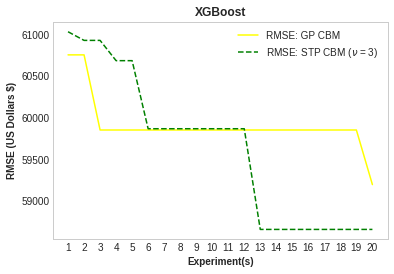

In [ ]:
### Visualise!

title = obj_func
plt.figure()

plt.plot(min_rmse_gp, color = 'Yellow', label='RMSE: GP CBM')
plt.plot(min_rmse_stp, color = 'Green', ls='--', label='RMSE: STP CBM ' r'($\nu$' ' = {})'.format(df))

plt.title(title, weight = 'bold')
plt.xlabel('Experiment(s)', weight = 'bold') # x-axis label
plt.ylabel('RMSE (US Dollars $)', weight = 'bold') # y-axis label
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(min_rmse_gp)
plt.xticks(np.arange(count), np.arange(1, count + 1))
plt.grid(b=None)
plt.show() #visualise!


In [ ]:
time_gp, time_stp


(1097.0747191905975, 977.0188040733337)

In [ ]:
min(min_rmse_stp), min(min_rmse_gp)


(58655.65989889668, 59194.599001987306)